In [578]:
"""
Title: Vistra Corp - Take Home Modeling Problem
Client: n/a
Date: 6/14/2024
Author: Myles Thomas
"""


'\nTitle: Vistra Corp - Take Home Modeling Problem\nClient: n/a\nDate: 6/14/2024\nAuthor: Myles Thomas\n'

In [579]:
import os
import holidays
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def convert_dtypes(df):
    """
    Converts columns in a DataFrame to numeric if possible, otherwise to categorical.
    
    Parameters:
    df (pd DataFrame): The DataFrame to convert.
    
    Returns:
    pd.DataFrame: The DataFrame with converted data types.
    """
    for column in df.columns:
        # Attempt to convert each column to numeric
        df[column] = pd.to_numeric(df[column], errors='ignore')
        # If the column is not numeric and is an object, convert it to categorical
        if df[column].dtype == 'object':
            df[column] = df[column].astype('category')
    return df

def set_datetime_index(df, column_name):
    """
    Sets a DataFrame's index to the datetime column provided.
    
    Parameters:
    df (pd DataFrame): The DataFrame to set the index for.
    column_name (str): The column in the DataFrame that holds the time/period information. 
    
    Returns:
    pd.DataFrame: The DataFrame set index.
    """
    if not pd.api.types.is_datetime64_any_dtype(df[column_name]):
        df[column_name] = pd.to_datetime(df[column_name])
    df.set_index(column_name, inplace=True)
    return df

def add_holiday_flags(df, country='US'):
    """
    Adds binary flags and holiday names to a DataFrame using the DataFrame's index as dates.
    
    Parameters:
    - df (pd.DataFrame): A DataFrame with its index set to datetime representing dates.
    - country (str): The country code to identify the applicable holiday calendar.
      Default is 'US' for United States.

    Returns:
    - pd.DataFrame: The original DataFrame with two new columns:
      'is_holiday' - a binary flag (1 if the date is a holiday, 0 otherwise).
      'holiday_name' - the name of the holiday on that date (None if not a holiday).
    """
    
    # Ensure the index is of datetime type
    df.index = pd.to_datetime(df.index)

    # Initialize holidays for the specified country
    holiday_calendar = holidays.CountryHoliday(country)

    # Add a binary flag for holidays and the holiday name using the DataFrame's index
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in holiday_calendar else 0)
    df['holiday_name'] = df.index.to_series().apply(lambda x: holiday_calendar.get(x))

    return df

SCRIPT_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(SCRIPT_DIR)
INPUT_DIR = os.path.join(PARENT_DIR, "00_INPUT/")
INTER_DIR = os.path.join(PARENT_DIR, "01_INTERMEDIATE/")
OUTPUT_DIR = os.path.join(PARENT_DIR, "02_OUTPUT/")

print(f"script directory: {SCRIPT_DIR}")


# Overview

- import and prepare data
- exploratory data analysis
- feature engineering
- training/test split
- model training and testing
- output MAE of test data
- plot predictions vs actuals in test set

## Import and Prepare Data


In [580]:
FILENAME_INPUT_DATA = "Wind_data.xlsx"

# Get all sheet names
excel_file = pd.ExcelFile(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA))
print(excel_file.sheet_names)

train_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Train")
test_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Predict")

train_data = train_data_full.copy()
test_data = test_data_full.copy()
print(train_data.shape)
print(test_data.shape)

train_data = set_datetime_index(df=train_data, column_name="DATETIME")
test_data = set_datetime_index(df=test_data, column_name="DATETIME")

In [581]:
train_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

In [582]:
train_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-07 19:00:00  0.004494        1.56        1.62        2.44        1.81   
2020-01-07 20:00:00  0.006143        1.51        1.55        2.13        1.93   
2020-01-07 21:00:00  0.008399        1.51        1.62        2.42        1.82   
2020-01-07 22:00:00  0.015788        1.53        1.73        2.22        1.83   
2020-01-07 23:00:00  0.011883        1.55        1.70        2.34        1.50   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-07 19:00:00        2.23        2.05        1.81        5.55   
2020-01-07 20:00:00        2.36        1.45        1.14        4.61   
2020-01-07 21:00:00        2.47        1.60        1.02        4.00   
2020-01-07 22:00:00        2.53        1.44        1.15        3.78   
2020-01-07 23:00:00        2.65        1.08        1.06        3.35   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-07 19:00:00        1.77  ...      1.41       1.56       1.04   
2020-01-07 20:00:00        2.06  ...      1.32       1.82       0.88   
2020-01-07 21:00:00        2.48  ...      1.26       2.09       1.28   
2020-01-07 22:00:00        2.71  ...      1.24       1.87       1.37   
2020-01-07 23:00:00        2.91  ...      1.39       1.41       1.20   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-07 19:00:00       1.48       1.55       1.94       1.72       1.30   
2020-01-07 20:00:00       1.12       1.32       1.87       1.81       1.42   
2020-01-07 21:00:00       0.87       1.37       1.83       2.08       1.44   
2020-01-07 22:00:00       1.05       1.06       1.83       1.61       1.54   
2020-01-07 23:00:00       1.27       0.86       1.81       1.41       1.06   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-07 19:00:00       1.22       1.60  
2020-01-07 20:00:00       1.05       1.87  
2020-01-07 21:00:00       1.32       2.05  
2020-01-07 22:00:00       1.47       2.05  
2020-01-07 23:00:00       1.17       1.47  

[5 rows x 113 columns]

In [583]:
test_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [584]:

test_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-12 16:00:00 NaN        3.12        2.62        4.04        6.08   
2020-01-12 17:00:00 NaN        2.79        2.31        4.25        5.95   
2020-01-12 18:00:00 NaN        2.86        2.44        3.95        6.13   
2020-01-12 19:00:00 NaN        2.81        2.20        4.32        6.07   
2020-01-12 20:00:00 NaN        2.35        1.71        4.12        5.90   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-12 16:00:00        1.07        2.42        2.00        6.50   
2020-01-12 17:00:00        1.59        3.96        1.73        7.42   
2020-01-12 18:00:00        2.58        2.58        1.56        7.36   
2020-01-12 19:00:00        1.93        2.02        1.61        6.72   
2020-01-12 20:00:00        2.10        1.99        1.70        6.36   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-12 16:00:00        1.18  ...      3.93       5.69       5.19   
2020-01-12 17:00:00        1.73  ...      3.58       4.90       4.59   
2020-01-12 18:00:00        2.40  ...      3.62       4.63       4.14   
2020-01-12 19:00:00        1.64  ...      3.95       6.02       4.20   
2020-01-12 20:00:00        1.74  ...      3.72       5.99       4.03   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-12 16:00:00       1.80       3.23       3.48       5.16       3.36   
2020-01-12 17:00:00       2.05       2.68       3.04       4.59       2.72   
2020-01-12 18:00:00       2.21       2.41       3.34       4.77       2.54   
2020-01-12 19:00:00       1.37       2.01       3.58       5.06       2.44   
2020-01-12 20:00:00       1.54       1.95       3.23       5.26       2.63   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-12 16:00:00       5.30       4.55  
2020-01-12 17:00:00       4.63       3.81  
2020-01-12 18:00:00       4.27       3.42  
2020-01-12 19:00:00       4.46       4.33  
2020-01-12 20:00:00       4.35       4.42  

[5 rows x 113 columns]

In [585]:
df = train_data.copy()

df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

It appears that we are dealing with hourly data. Let's check to see if there are any gaps, and if so, to fill them LATER on in the modeling process.
- Method to fill: Forward filling
    - Rationale: Forward filling Doesn't use future information
    - Backward fill can potentially introduce data leakage
- Reason for not filling now: Could introduce bias in the feature engineering phase due to duplicate values
    - Will have to fill before using ML for time series forecasting but we can do that later on in the process


## Exploratory Data Analysis

In [586]:
response_var = 'CF'

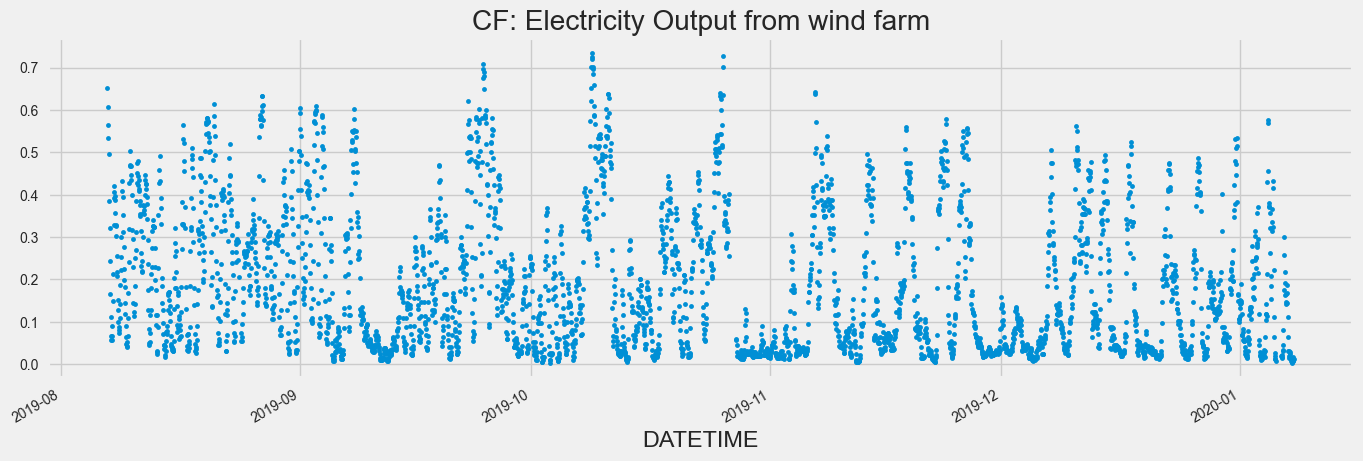

In [587]:
df[response_var].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='CF: Electricity Output from wind farm')
plt.show()

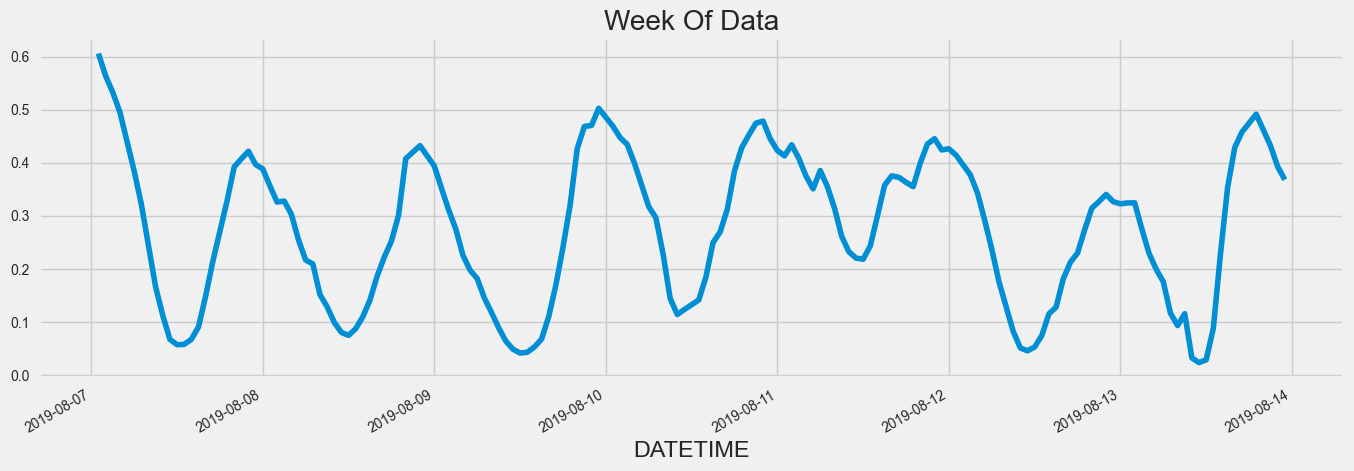

In [588]:
# Looking at just 1 week of data to try and understand trends
date_str_begin = df.index.min()
date_str_end = df.index.min() + pd.Timedelta(days=7)
df[response_var].loc[(df.index > date_str_begin) & (df.index < date_str_end)] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

The trends appears to be daily ie. every 24 hours

In [589]:
corr = df.corr()
corr

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
CF          1.000000    0.724801    0.710433    0.170152    0.428863   
WS_1133733  0.724801    1.000000    0.985250    0.093646    0.686344   
WS_1156770  0.710433    0.985250    1.000000    0.098417    0.648143   
WS_1156968  0.170152    0.093646    0.098417    1.000000    0.082770   
WS_1182195  0.428863    0.686344    0.648143    0.082770    1.000000   
...              ...         ...         ...         ...         ...   
WS_883699   0.704502    0.982857    0.951172    0.120650    0.735884   
WS_914573   0.579387    0.802751    0.765396    0.105214    0.934309   
WS_918665   0.811993    0.572185    0.560684    0.164981    0.472534   
WS_920775   0.757800    0.557232    0.540939    0.163066    0.518533   
WS_921049   0.726670    0.530611    0.506068    0.190156    0.521042   

            WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  ...  \
CF            0.594679    0.227482    0.417947   -0.169850    0.596089  ...   
WS_1133733    0.476048    0.328725    0.255731   -0.013081    0.469620  ...   
WS_1156770    0.499236    0.336916    0.275703   -0.009782    0.496980  ...   
WS_1156968    0.251306    0.061329    0.321191    0.132907    0.257602  ...   
WS_1182195    0.113371    0.325802    0.158332    0.298286    0.098624  ...   
...                ...         ...         ...         ...         ...  ...   
WS_883699     0.446078    0.353438    0.254178    0.071334    0.432541  ...   
WS_914573     0.233872    0.319011    0.220036    0.129267    0.227081  ...   
WS_918665     0.364441    0.243132    0.397946   -0.038026    0.365625  ...   
WS_920775     0.312791    0.322186    0.362466    0.109579    0.299610  ...   
WS_921049     0.286014    0.325550    0.354097    0.074670    0.267745  ...   

            WS_78208  WS_811655  WS_839753  WS_875373  WS_883683  WS_883699  \
CF          0.720730   0.477331   0.777407   0.674839   0.823975   0.704502   
WS_1133733  0.977686   0.383380   0.605827   0.520335   0.585449   0.982857   
WS_1156770  0.936457   0.353987   0.592340   0.535498   0.581282   0.951172   
WS_1156968  0.094072   0.196005   0.146150   0.162616   0.149913   0.120650   
WS_1182195  0.742120   0.520854   0.519008   0.145412   0.437179   0.735884   
...              ...        ...        ...        ...        ...        ...   
WS_883699   0.984297   0.444009   0.619312   0.481247   0.574338   1.000000   
WS_914573   0.843784   0.471507   0.568945   0.290998   0.522104   0.828129   
WS_918665   0.596020   0.709479   0.928278   0.437765   0.984448   0.570079   
WS_920775   0.593694   0.811089   0.981908   0.365620   0.931039   0.575591   
WS_921049   0.580095   0.892618   0.904714   0.342674   0.878944   0.556787   

            WS_914573  WS_918665  WS_920775  WS_921049  
CF           0.579387   0.811993   0.757800   0.726670  
WS_1133733   0.802751   0.572185   0.557232   0.530611  
WS_1156770   0.765396   0.560684   0.540939   0.506068  
WS_1156968   0.105214   0.164981   0.163066   0.190156  
WS_1182195   0.934309   0.472534   0.518533   0.521042  
...               ...        ...        ...        ...  
WS_883699    0.828129   0.570079   0.575591   0.556787  
WS_914573    1.000000   0.543307   0.554357   0.550749  
WS_918665    0.543307   1.000000   0.949290   0.933567  
WS_920775    0.554357   0.949290   1.000000   0.939755  
WS_921049    0.550749   0.933567   0.939755   1.000000  

[113 rows x 113 columns]

In [590]:
# Create a DataFrame from the upper triangle of the correlation matrix, excluding the diagonal
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Set number of top correlations to display
n = 50

# Sort the pairs by absolute correlation magnitude, descending
top_n_corr = corr_pairs.assign(AbsCorrelation=corr_pairs['Correlation'].abs()).sort_values('AbsCorrelation', ascending=False).head(n)

# Drop the absolute value column if not needed in final display
top_n_corr = top_n_corr.drop('AbsCorrelation', axis=1)

# Display the top n correlations
print(top_n_corr)

There appears to be some very highly correlated variables among these Wind Speed measurements from different locations.

## Feature Engineering

One technique that I like to use, that I find works better than removing correlated features, is to combine the nuance of all of these correlated features by feeding them in a decision tree. Typically, this will uncover relationships in the data that we may not have discovered by another more traditional dimension reduction method.

First iteration of the baseline model: No tuning

In [591]:
response_var = 'CF'

In [592]:
# Feature Engineering: Add correlated variables to a decision tree that predicts the output
df.sort_index(inplace=True)
X = df.drop(response_var, axis=1)  # All columns except 'y'
y = df[response_var]

# split_index = int(len(df) * 0.8)
# split_date = df.index[split_index]
# print(f"split_date: {split_date}")

# # Splitting the data into training and testing based on the date
# train = df[df.index <= split_date]
# test = df[df.index > split_date]

# # Splitting the data into features and target
# X_train = train.drop([response_var,], axis=1)  # Dropping 'y'
# y_train = train[response_var]
# X_test = test.drop([response_var,], axis=1)
# y_test = test[response_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(
    random_state=42
)

decision_tree.fit(X_train, y_train)

decision_tree


DecisionTreeRegressor(random_state=42)

In [593]:
# y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

In [594]:
from sklearn.model_selection import cross_val_score, KFold

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(decision_tree, X, y, cv=cv, scoring='neg_mean_squared_error')

# Calculate average MSE
mean_mse = np.mean(scores)
std_mse = np.std(scores)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

Let's see if we can improve the performance via hyperparameter tuning with grid search:

In [595]:
# Decision Tree Regressor initialization
dtree = DecisionTreeRegressor(random_state=42)

# Parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None,'sqrt', 'log2'] # removed 'auto'
}

# Setup the grid search
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1, 
    error_score='raise'
)

# Perform grid search
try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Error during grid search: {e}")

# Best estimator found by GridSearchCV
best_dtree = grid_search.best_estimator_

# Predicting and evaluating using the best estimator
y_pred_test = best_dtree.predict(X_test)
test_error = mean_squared_error(y_test, y_pred_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test MSE: {test_error}") # using mse with this model since it is more sensitive to large outliers

In [596]:
y_test_pred = y_pred_test
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

In [597]:
y_pred_all = best_dtree.predict(X)
y_pred_all_df = pd.Series(y_pred_all, index=y.index)
y_pred_all_df

DATETIME
2019-08-07 00:00:00    0.666727
2019-08-07 01:00:00    0.666727
2019-08-07 02:00:00    0.501278
2019-08-07 03:00:00    0.501278
2019-08-07 04:00:00    0.501278
                         ...   
2020-01-07 19:00:00    0.016742
2020-01-07 20:00:00    0.016742
2020-01-07 21:00:00    0.016742
2020-01-07 22:00:00    0.016742
2020-01-07 23:00:00    0.016742
Length: 3635, dtype: float64

In [598]:
assert y.shape[0] == y_pred_all_df.shape[0]

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

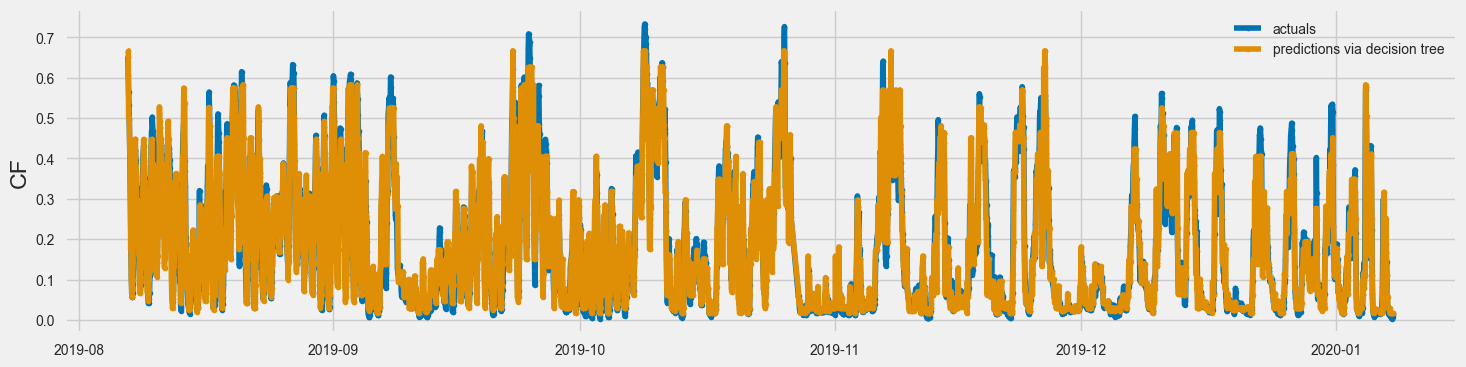

In [599]:
from sktime.utils.plotting import plot_series

plot_series(
    y, y_pred_all_df,
    # pd.Series(y_pred_train, index=y_train.index), pd.Series(y_pred_test, index=y_test.index),
    labels=['actuals', 'predictions via decision tree', ] # 'y_pred_train', 'y_pred_test',
)

This decision tree is doing a solid job of mapping the different measurements of wind to the hourly electricity output from a wind farm.

Here is the decision tree visualized, which is very helpful for model explainability/communicating with non-technical audiences due to its binary nature:

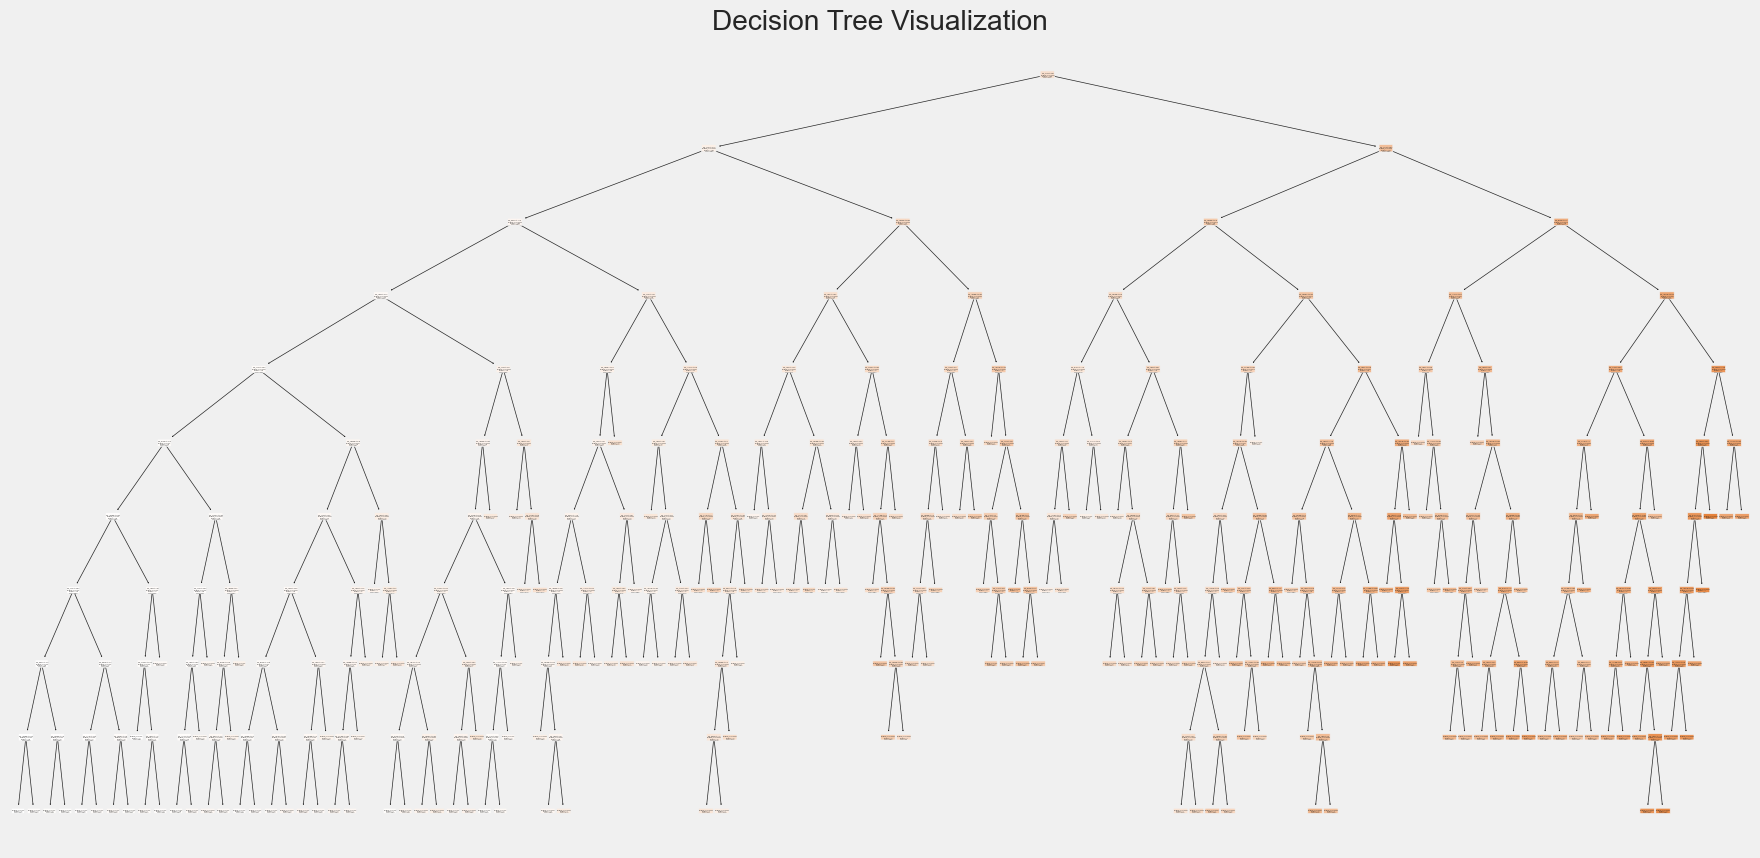

In [600]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(best_dtree, filled=True, feature_names=list(X.columns), rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


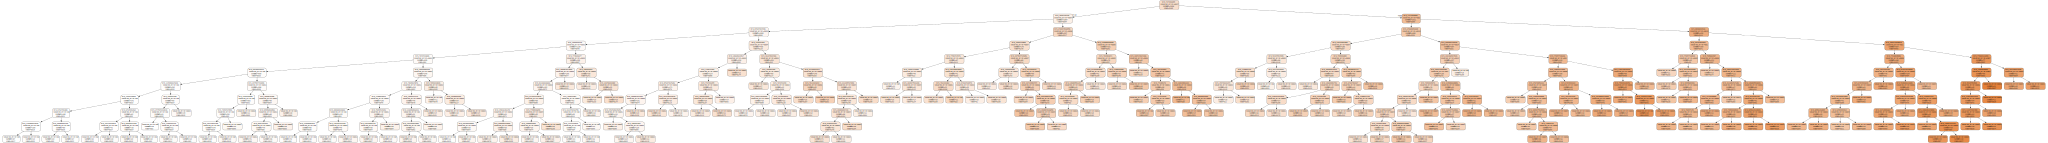

In [601]:
from sklearn.tree import export_graphviz
import graphviz

# Export as dot file
dot_data = export_graphviz(best_dtree, out_file=None, 
                           feature_names=X.columns,
                           filled=True, rounded=True,  
                           special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


I will try to optimize this ensemble model even further by branching into models other than the decision tree. Namely, ...

In [602]:
# PyCaret for automated ML
# pip install pycaret[full] to make sure that all models run
# note; has some dependency issues with sktime, may want to pip download this THEN sktime
from pycaret.regression import setup, compare_models, evaluate_model, predict_model, save_model, load_model

In [603]:
# create an experiment
s = setup(df, target=response_var)

In [604]:
best_model = compare_models() # search for best model

In [605]:
evaluate_model(best_model) # check performance, look at hyperparams/feature importance

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [606]:
y_pred = predict_model(best_model, data=X_test) # make predictions

In [607]:
y_pred['prediction_label']

DATETIME
2019-09-30 14:00:00    0.038999
2019-08-12 07:00:00    0.166401
2019-09-11 20:00:00    0.095309
2019-10-10 22:00:00    0.558221
2019-12-07 06:00:00    0.324412
                         ...   
2019-08-21 19:00:00    0.340001
2019-10-15 17:00:00    0.083141
2019-10-13 05:00:00    0.029093
2019-09-05 03:00:00    0.095323
2019-10-23 04:00:00    0.216594
Name: prediction_label, Length: 727, dtype: float64

In [608]:
test_mse = mean_squared_error(y_test, y_pred['prediction_label'])
test_mae = mean_absolute_error(y_test, y_pred['prediction_label'])

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

In [609]:
# save model for use later
# save_model(best_model, "lgbm_regressor")
save_model(best_model, os.path.join(INTER_DIR, "optimal_model"))


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                              'WS_1156968', 'WS_1182195',
                                              'WS_1193865', 'WS_1321569',
                                              'WS_1324653', 'WS_1358699',
                                              'WS_1366338', 'WS_1366351',
                                              'WS_1369320', 'WS_1461024',
                                              'WS_1481513', 'WS_1504146',
                                              'WS_1513782', 'WS_1513805',
                                              'WS_1571308', 'WS_1574484',
                                              'WS_1625339', 'WS_16253...
                                              'WS_1628663', 'WS_1681085',
                                              'WS_1820276', 'WS_1820279',
                                  

In [610]:
# check that loading works (will need to load it later, so testing now)
model = load_model(os.path.join(INTER_DIR, "optimal_model"))
model

Pipeline(memory=FastMemory(location=C:\Users\Myles\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                             'WS_1156968', 'WS_1182195',
                                             'WS_1193865', 'WS_1321569',
                                             'WS_1324653', 'WS_1358699',
                                             'WS_1366338', 'WS_1366351',
                                             'WS_1369320', 'WS_1461024',
                                             'WS_1481513', 'WS_1504146',
                                             'WS_1513782', 'WS_1513805',
                                             'WS_1571...
                                             'WS_1628663', 'WS_1681085',
                                             'WS_1820276', 'WS_1820279',
                                             'WS_1899876', 'WS_1911282',
                                             'WS_1937650', 'WS_1937653',
                                             'WS_1953863', 'WS_1960535', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x00000113BD71F550>)])

In [611]:
y_pred_all = model.predict(X)
y_pred_all_df = pd.Series(y_pred_all, index=y.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

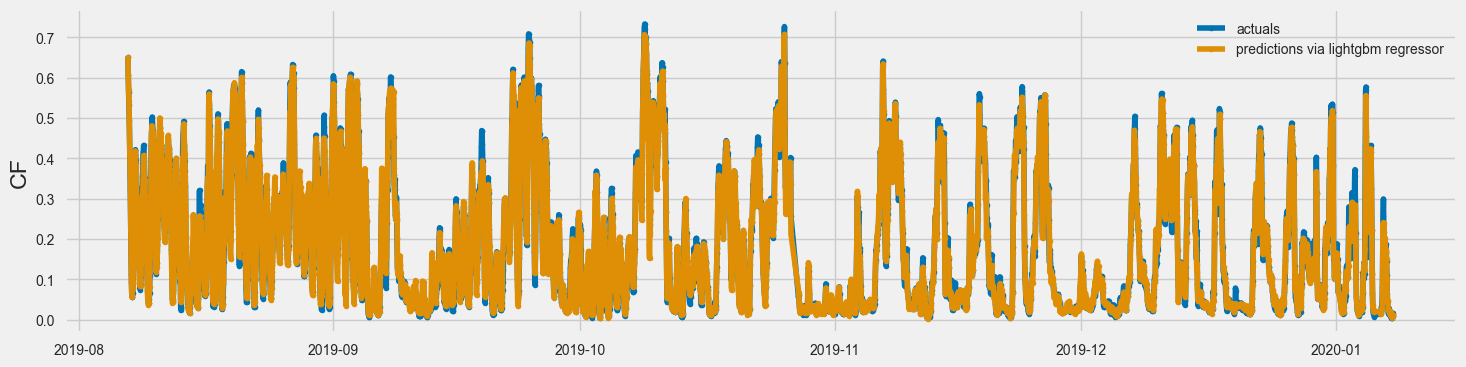

In [612]:
plot_series(
    y, y_pred_all_df,
    # pd.Series(y_pred_train, index=y_train.index), pd.Series(y_pred_test, index=y_test.index),
    labels=['actuals', 'predictions via lightgbm regressor', ] # 'y_pred_train', 'y_pred_test',
)

## More Feature Engineering and EDA

Looking at features that can be derived from dates:

In [613]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Ensure the index is of datetime type
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    # df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # 0=Monday, 6=Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Add holidays
    df = add_holiday_flags(df, country='US')
    return df

In [614]:
df = df[response_var].to_frame()

# df['prediction_wind_decision_tree'] = pd.Series(y_pred_all, index=y.index)
df['prediction_wind_decision_tree'] = pd.Series(y_pred_all, index=y.index)

df = create_features(df)

df

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.650762     0          2   
2019-08-07 01:00:00  0.605852                       0.606949     1          2   
2019-08-07 02:00:00  0.564094                       0.569131     2          2   
2019-08-07 03:00:00  0.532721                       0.542365     3          2   
2019-08-07 04:00:00  0.495608                       0.490843     4          2   
...                       ...                            ...   ...        ...   
2020-01-07 19:00:00  0.004494                       0.004969    19          1   
2020-01-07 20:00:00  0.006143                       0.011858    20          1   
2020-01-07 21:00:00  0.008399                       0.011577    21          1   
2020-01-07 22:00:00  0.015788                       0.012008    22          1   
2020-01-07 23:00:00  0.011883                       0.009622    23          1   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00        3      8  2019        219           7          32   
2019-08-07 01:00:00        3      8  2019        219           7          32   
2019-08-07 02:00:00        3      8  2019        219           7          32   
2019-08-07 03:00:00        3      8  2019        219           7          32   
2019-08-07 04:00:00        3      8  2019        219           7          32   
...                      ...    ...   ...        ...         ...         ...   
2020-01-07 19:00:00        1      1  2020          7           7           2   
2020-01-07 20:00:00        1      1  2020          7           7           2   
2020-01-07 21:00:00        1      1  2020          7           7           2   
2020-01-07 22:00:00        1      1  2020          7           7           2   
2020-01-07 23:00:00        1      1  2020          7           7           2   

                     is_holiday holiday_name  
2019-08-07 00:00:00           0         None  
2019-08-07 01:00:00           0         None  
2019-08-07 02:00:00           0         None  
2019-08-07 03:00:00           0         None  
2019-08-07 04:00:00           0         None  
...                         ...          ...  
2020-01-07 19:00:00           0         None  
2020-01-07 20:00:00           0         None  
2020-01-07 21:00:00           0         None  
2020-01-07 22:00:00           0         None  
2020-01-07 23:00:00           0         None  

[3635 rows x 12 columns]

## Visualize our Feature / Target Relationship

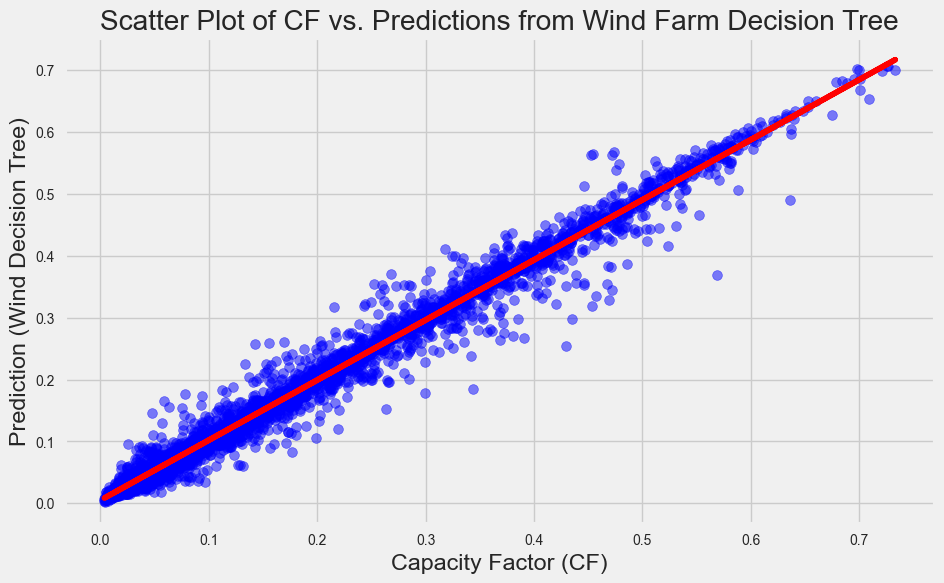

In [615]:
plt.figure(figsize=(10, 6))
plt.scatter(df['CF'], df['prediction_wind_decision_tree'], color='blue', alpha=0.5)
m, b = np.polyfit(df['CF'], df['prediction_wind_decision_tree'], 1)
plt.plot(df['CF'], m*df['CF'] + b, color='red')  # Add the line equation
plt.title('Scatter Plot of CF vs. Predictions from Wind Farm Decision Tree')
plt.xlabel('Capacity Factor (CF)')
plt.ylabel('Prediction (Wind Decision Tree)')
plt.grid(True)
plt.show()

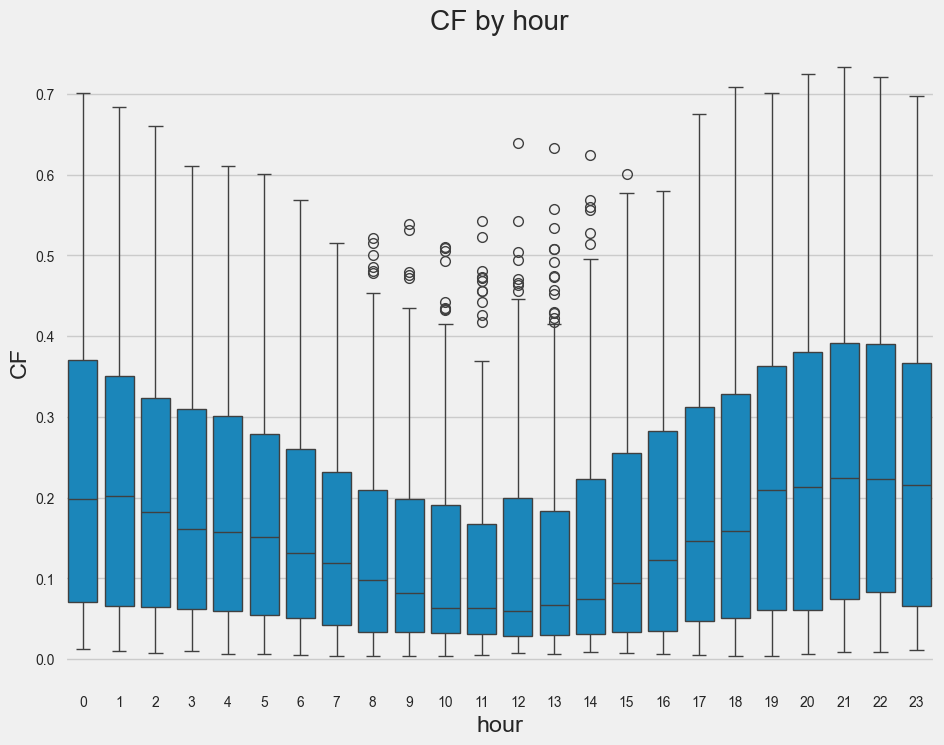

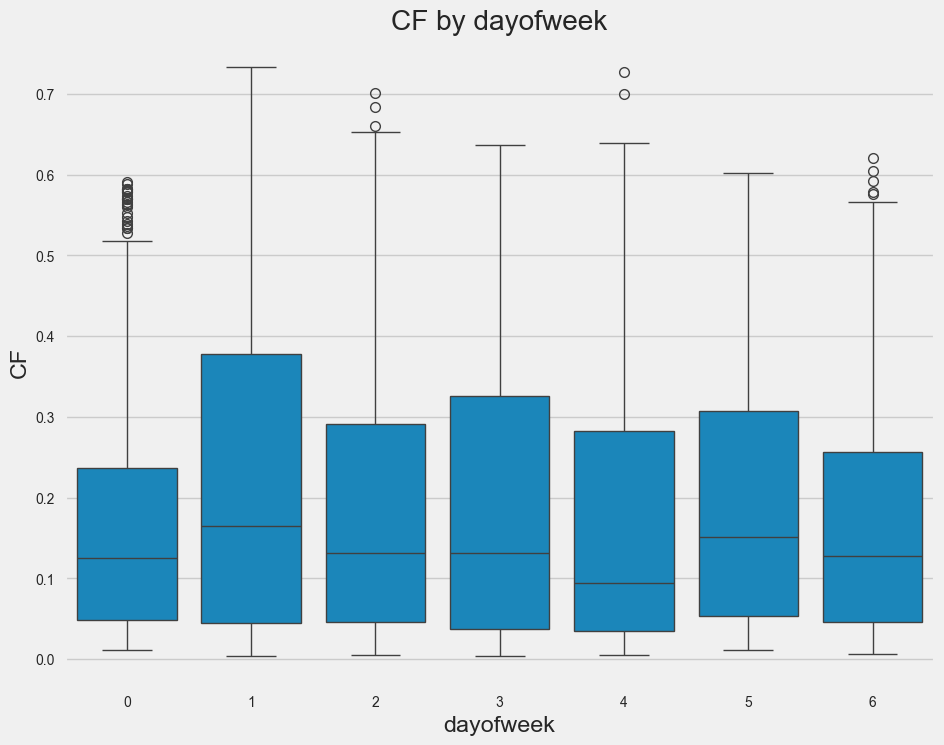

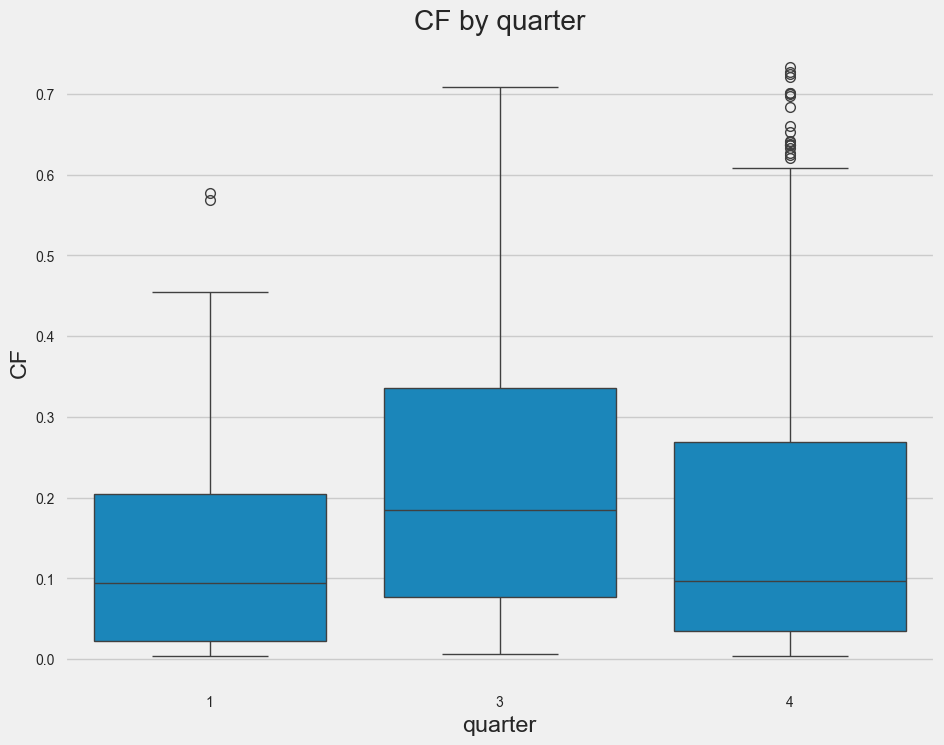

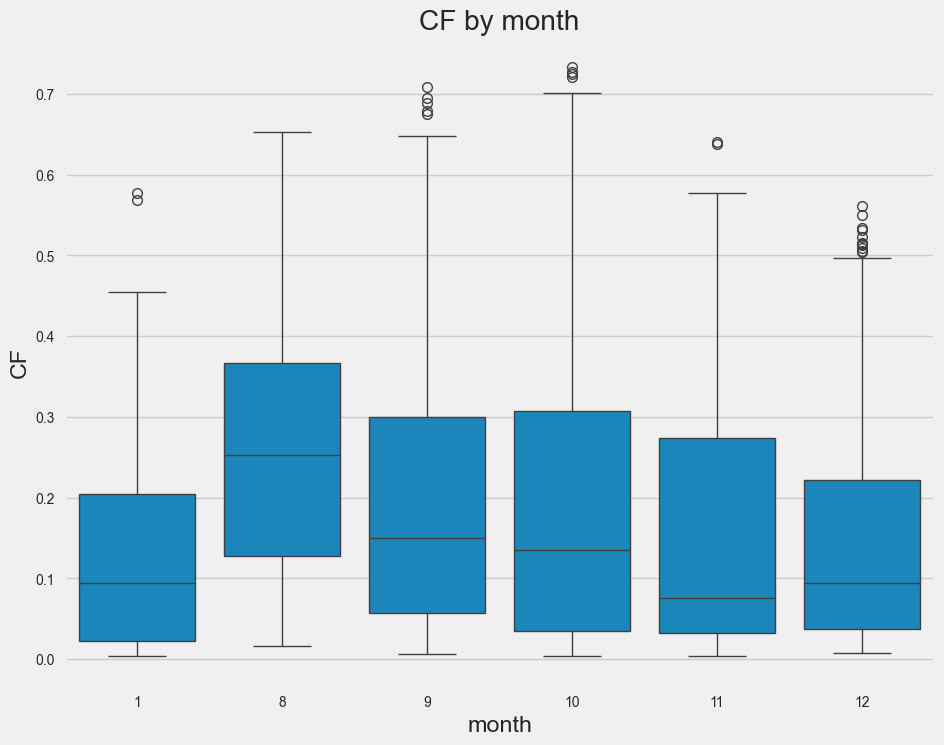

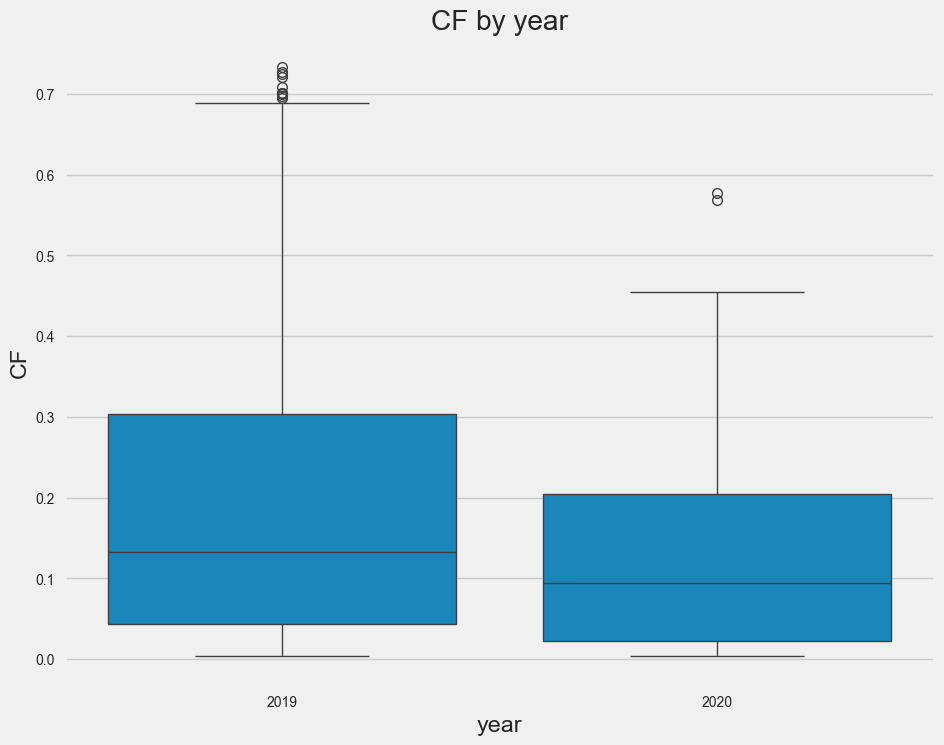

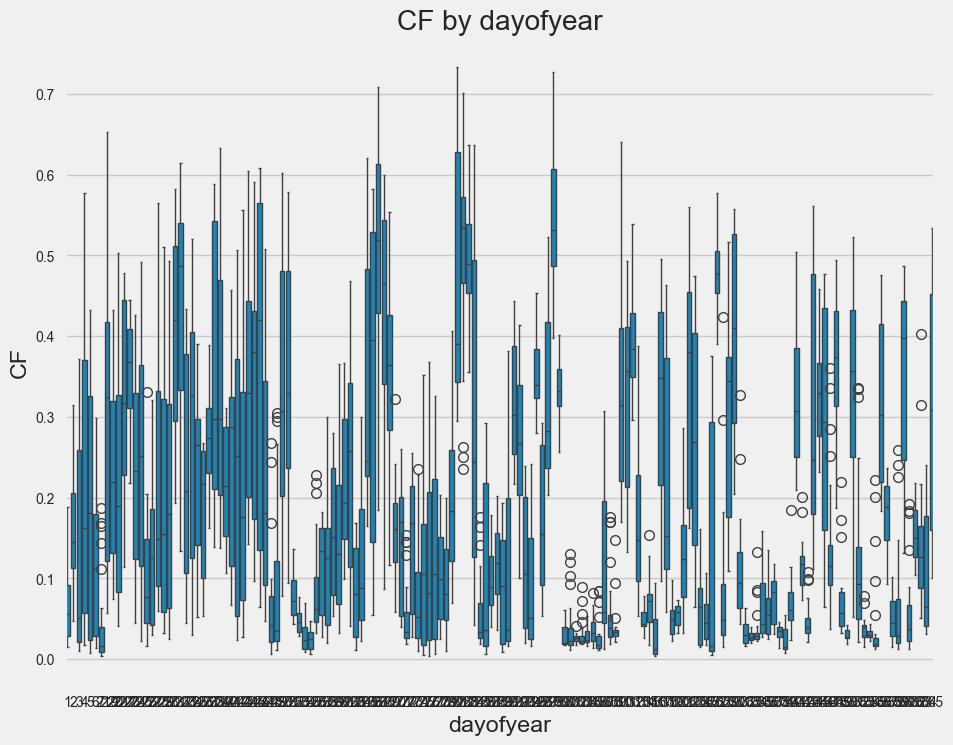

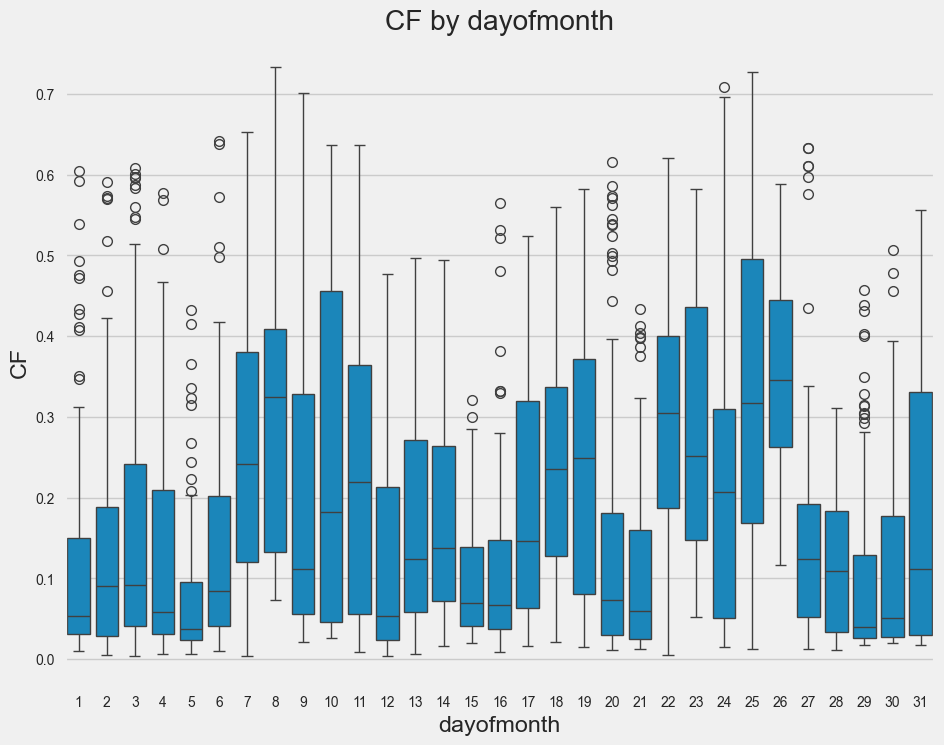

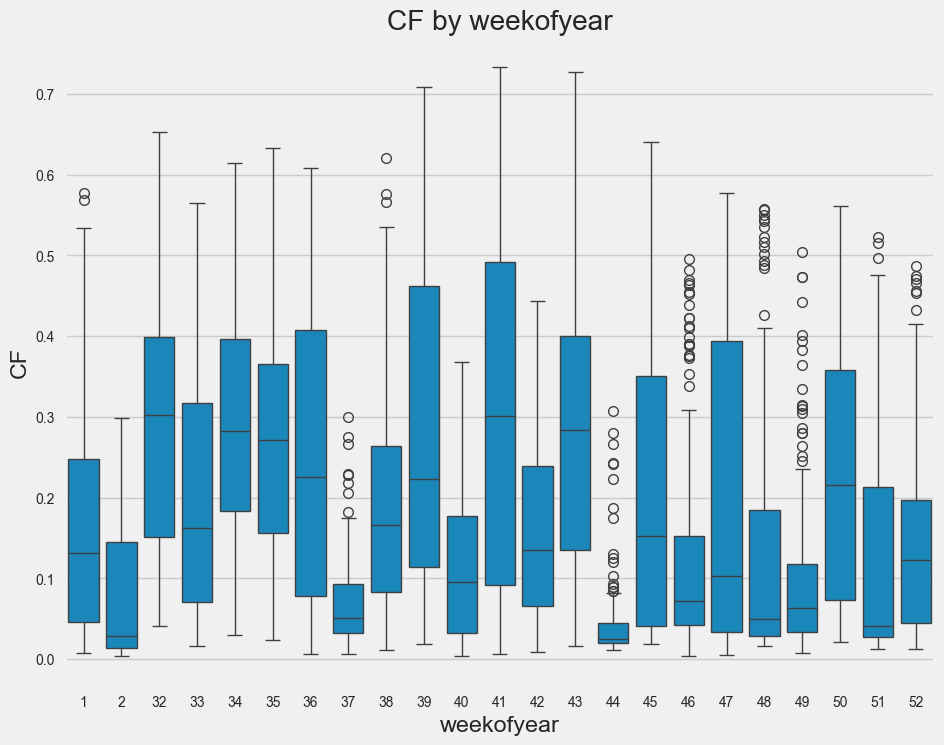

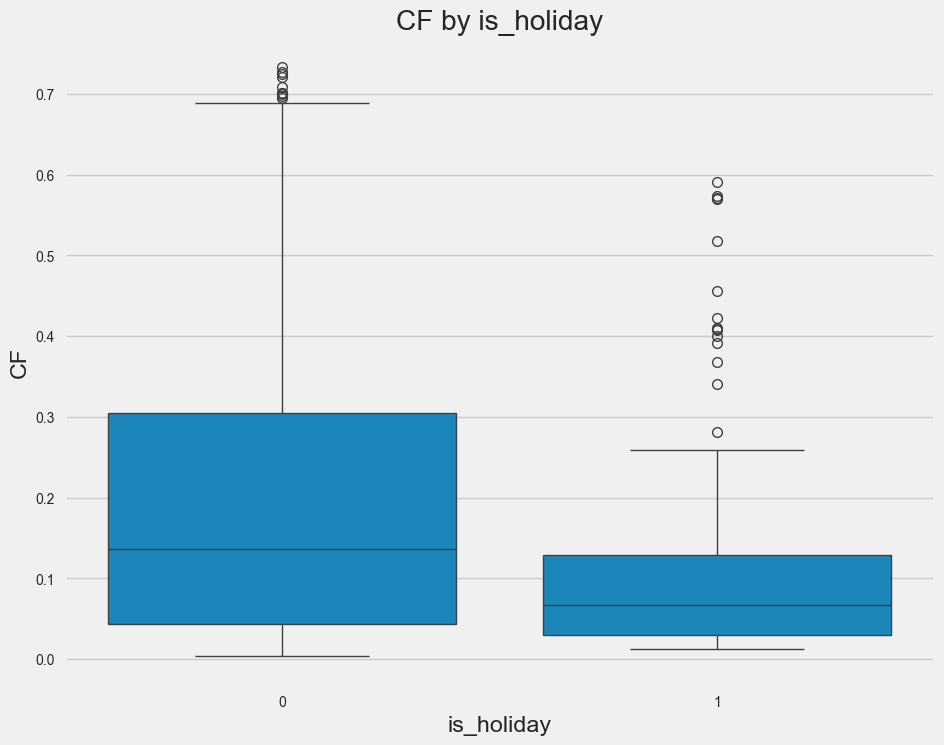

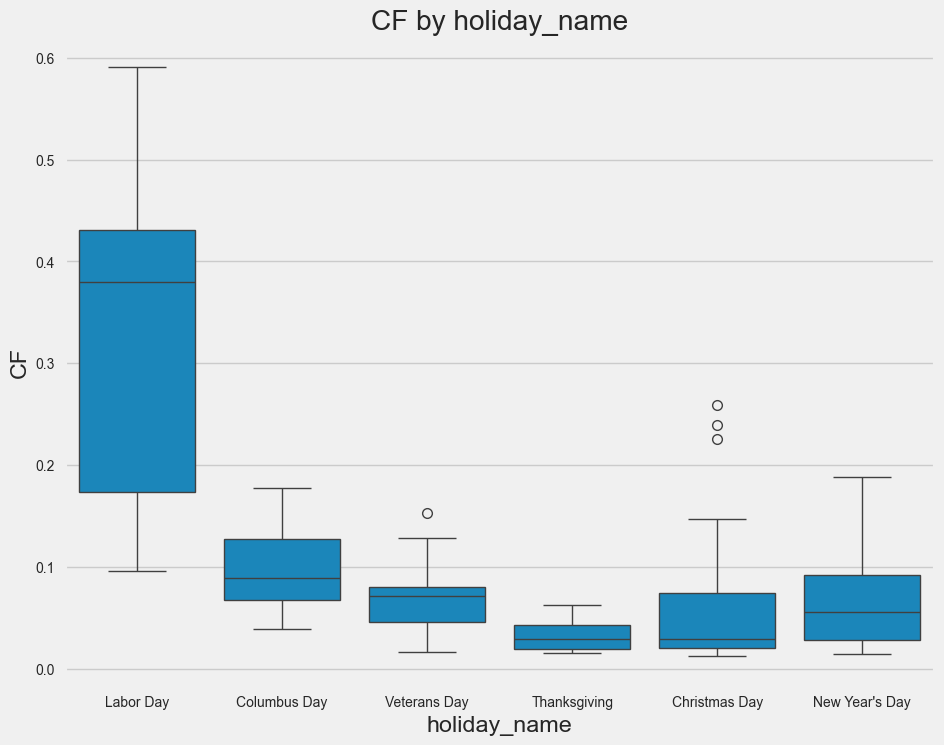

In [616]:
for column in df.columns:
    if column not in [response_var, 'prediction_wind_decision_tree']:
        predictor = column
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.boxplot(data=df, x=predictor, y=response_var)
        ax.set_title(f'{response_var} by {predictor}')
        plt.show()

Notable trends:
- prediction_wind_decision_tree: The wind farm decision tree does a pretty good job of mapping to the Average electricity output
- hour: Average electricity output appears to follow a trend where it is higher during the morning, dips during the afternoon, and increases again in the evening (this is intuitive with human behavior)
- quarter: Average electricity output appears to be higher in quarter 3 (unclear why)
- month: Average electricity output spikes in August
- year: Average electricity output is higher in 2019 (note: we just don't have much data on 2020 yet)
- dayofmonth: Average electricity output is quite erratic, I am also not sure if this is intuitive given that the day of the month shouldn't affect human behavior in the way that dayofweek may
- weekofyear: Similar story
- is_holiday: Average electricity output is noticeably lower on holidays
- holiday_name: Of the holiday's labor day bucks this trend with an extremely high Average electricity output

In [617]:
# get dummy variables for holiday
df = pd.get_dummies(df)
del df['is_holiday']

df

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.650762     0          2   
2019-08-07 01:00:00  0.605852                       0.606949     1          2   
2019-08-07 02:00:00  0.564094                       0.569131     2          2   
2019-08-07 03:00:00  0.532721                       0.542365     3          2   
2019-08-07 04:00:00  0.495608                       0.490843     4          2   
...                       ...                            ...   ...        ...   
2020-01-07 19:00:00  0.004494                       0.004969    19          1   
2020-01-07 20:00:00  0.006143                       0.011858    20          1   
2020-01-07 21:00:00  0.008399                       0.011577    21          1   
2020-01-07 22:00:00  0.015788                       0.012008    22          1   
2020-01-07 23:00:00  0.011883                       0.009622    23          1   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00        3      8  2019        219           7          32   
2019-08-07 01:00:00        3      8  2019        219           7          32   
2019-08-07 02:00:00        3      8  2019        219           7          32   
2019-08-07 03:00:00        3      8  2019        219           7          32   
2019-08-07 04:00:00        3      8  2019        219           7          32   
...                      ...    ...   ...        ...         ...         ...   
2020-01-07 19:00:00        1      1  2020          7           7           2   
2020-01-07 20:00:00        1      1  2020          7           7           2   
2020-01-07 21:00:00        1      1  2020          7           7           2   
2020-01-07 22:00:00        1      1  2020          7           7           2   
2020-01-07 23:00:00        1      1  2020          7           7           2   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                       False                      False   
2019-08-07 01:00:00                       False                      False   
2019-08-07 02:00:00                       False                      False   
2019-08-07 03:00:00                       False                      False   
2019-08-07 04:00:00                       False                      False   
...                                         ...                        ...   
2020-01-07 19:00:00                       False                      False   
2020-01-07 20:00:00                       False                      False   
2020-01-07 21:00:00                       False                      False   
2020-01-07 22:00:00                       False                      False   
2020-01-07 23:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                   False                        False   
2019-08-07 01:00:00                   False                        False   
2019-08-07 02:00:00                   False                        False   
2019-08-07 03:00:00                   False                        False   
2019-08-07 04:00:00                   False                        False   
...                                     ...                          ...   
2020-01-07 19:00:00                   False                        False   
2020-01-07 20:00:00                   False                        False   
2020-01-07 21:00:00                   False                        False   
2020-01-07 22:00:00                   False                        False   
2020-01-07 23:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                      False                      False  
2019-08-07 01:00:00                      False                      False  
2019-08-07 02:0

Before ML modeling, we need to make sure to have a true hourly dataset ie. a row of data at each hourly interval.

In [618]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

The only differences between rows of data should be NA (beginning and end), and 1 hour (all data in between), so this is something we need to fix.

In [619]:
import pandas as pd

def ensure_hourly_frequency(df):
    """
    Reindexes a DataFrame to ensure it has an hourly frequency, filling any missing timestamps.

    This function calculates the minimum and maximum datetime indices of the DataFrame, 
    creates a new DateTimeIndex with hourly intervals within this range, and reindexes 
    the DataFrame using this hourly index. Missing data points are forward-filled to avoid data leakage.

    Parameters:
    df (pd.DataFrame): DataFrame with a DateTimeIndex that needs to be set to a regular hourly frequency.

    Returns:
    pd.DataFrame: The reindexed DataFrame with hourly frequency, where missing data points have been forward-filled.
    """
    # Calculate the start and end of the DataFrame's index
    start = df.index.min()
    end = df.index.max()
    print(start, end)

    # Create a full hourly DateTimeIndex from start to end
    full_index = pd.date_range(start=start, end=end, freq='H')

    # Reindex the DataFrame to this new index, forward filling missing values
    # df = df.reindex(full_index, method='ffill')
    df = df.reindex(full_index, method=None)

    return df

df = ensure_hourly_frequency(df=df)


In [620]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

We just introduced NA into our dataset. Because we do not have prediction data for wind model for every timestamp, we are going to have to forward fill the values from the wind prediction model and the response variable (`CF`).

As you have seen during the EDA section, the data follows a daily/weekly trends, so I will try out using the past day's information first.

In [621]:
df.index

DatetimeIndex(['2019-08-07 00:00:00', '2019-08-07 01:00:00',
               '2019-08-07 02:00:00', '2019-08-07 03:00:00',
               '2019-08-07 04:00:00', '2019-08-07 05:00:00',
               '2019-08-07 06:00:00', '2019-08-07 07:00:00',
               '2019-08-07 08:00:00', '2019-08-07 09:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=3696, freq='H')

In [622]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

In [623]:
# grabbing some indices to check how they were filled
indices_list = df[df['CF'].isna()].index
print(len(indices_list))

In [624]:
def custom_ffill(df, columns, hours_back):
    """
    Custom forward fill function that fills NaNs for multiple columns based on the value from 'hours_back' hours ago.
    Uses the datetime index directly.
    """
    time_delta = pd.Timedelta(hours=hours_back)
    
    for column in columns:
        # Apply a custom function to fill NaNs by looking 'hours_back'
        df[column] = df[column].combine_first(
            df.index.to_series().apply(lambda dt: df.at[dt - time_delta, column] if (dt - time_delta) in df.index else np.nan)
        )
    
    return df

# Forward fill based on the last day (24 hours back)
df = custom_ffill(df, list(df.columns), 24)

# Forward fill based on the last week (168 hours back)
# df = custom_ffill(df, list(df.columns), 168)


In [625]:
# Ensuring a value from before was filled with yesterday's value
idx = indices_list[25]
print(idx)

In [626]:
time_delta = pd.Timedelta(hours=24)

idx_one_day_prior = idx - time_delta
print(idx_one_day_prior)

In [627]:
# These should be the same data
df[df.index == idx]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-10-26 21:00:00  0.726732                        0.70723  21.0        4.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-10-26 21:00:00      4.0   10.0  2019.0      298.0        25.0   

                     weekofyear holiday_name_Christmas Day  \
2019-10-26 21:00:00          43                      False   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-10-26 21:00:00                     False                  False   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-10-26 21:00:00                       False                     False   

                    holiday_name_Veterans Day  
2019-10-26 21:00:00                     False

In [628]:
# These should be the same data
df[df.index == idx_one_day_prior]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-10-25 21:00:00  0.726732                        0.70723  21.0        4.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-10-25 21:00:00      4.0   10.0  2019.0      298.0        25.0   

                     weekofyear holiday_name_Christmas Day  \
2019-10-25 21:00:00          43                      False   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-10-25 21:00:00                     False                  False   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-10-25 21:00:00                       False                     False   

                    holiday_name_Veterans Day  
2019-10-25 21:00:00                     False

In [629]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

In [630]:
df[df['CF'].isna()]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 05:00:00 NaN                            NaN   NaN        NaN   
2019-08-07 18:00:00 NaN                            NaN   NaN        NaN   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 05:00:00      NaN    NaN   NaN        NaN         NaN        <NA>   
2019-08-07 18:00:00      NaN    NaN   NaN        NaN         NaN        <NA>   

                    holiday_name_Christmas Day holiday_name_Columbus Day  \
2019-08-07 05:00:00                        NaN                       NaN   
2019-08-07 18:00:00                        NaN                       NaN   

                    holiday_name_Labor Day holiday_name_New Year's Day  \
2019-08-07 05:00:00                    NaN                         NaN   
2019-08-07 18:00:00                    NaN                         NaN   

                    holiday_name_Thanksgiving holiday_name_Veterans Day  
2019-08-07 05:00:00                       NaN                       NaN  
2019-08-07 18:00:00                       NaN                       NaN

In [631]:
df.iloc[4:6]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 04:00:00  0.495608                       0.490843   4.0        2.0   
2019-08-07 05:00:00       NaN                            NaN   NaN        NaN   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 05:00:00      NaN    NaN     NaN        NaN         NaN   

                     weekofyear holiday_name_Christmas Day  \
2019-08-07 04:00:00          32                      False   
2019-08-07 05:00:00        <NA>                        NaN   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-08-07 04:00:00                     False                  False   
2019-08-07 05:00:00                       NaN                    NaN   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-08-07 04:00:00                       False                     False   
2019-08-07 05:00:00                         NaN                       NaN   

                    holiday_name_Veterans Day  
2019-08-07 04:00:00                     False  
2019-08-07 05:00:00                       NaN

In [632]:
# Fill with value from the hour beforehand if we don't have data from a week ago
# (ie. this value in the 7th row doesn't have anything to look back at, so we will use the previous hour's here)
if df['CF'].isna().sum() > 0:
    print(f"filled {df['CF'].isna().sum()} values via forward fill from last hour")
    df = df.fillna(method="ffill")

In [633]:
# 6th row was filled with info from row 5
df.iloc[4:6]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 04:00:00  0.495608                       0.490843   4.0        2.0   
2019-08-07 05:00:00  0.495608                       0.490843   4.0        2.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 05:00:00      3.0    8.0  2019.0      219.0         7.0   

                     weekofyear  holiday_name_Christmas Day  \
2019-08-07 04:00:00          32                       False   
2019-08-07 05:00:00          32                       False   

                     holiday_name_Columbus Day  holiday_name_Labor Day  \
2019-08-07 04:00:00                      False                   False   
2019-08-07 05:00:00                      False                   False   

                     holiday_name_New Year's Day  holiday_name_Thanksgiving  \
2019-08-07 04:00:00                        False                      False   
2019-08-07 05:00:00                        False                      False   

                     holiday_name_Veterans Day  
2019-08-07 04:00:00                      False  
2019-08-07 05:00:00                      False

In [634]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

In [635]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

In [636]:
def prepare_data_for_sktime(df):
    """
    Converts numerical columns in the provided DataFrame to float64, 
    a format compatible with sktime forecasting models.

    This function iterates through each column in the DataFrame, checking the data type. 
    If the data type of a column is either UInt32 or Float64, it converts the column to float64.
    This ensures that all numerical data is in a consistent format expected by sktime models.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be prepared.

    Returns:
    pandas.DataFrame: The DataFrame with numerical columns converted to float64.
    
    Prints:
    The name of each column that is converted, along with its data type before and after conversion.
    """
    for column_name, column_dtype in zip(df.columns, df.dtypes):
        if column_dtype in ["UInt32", "Float64"]:
            print(column_name)
            print(f"before: {column_dtype}")
            df[column_name] = df[column_name].astype('float64')
            print(f"after: {df[column_name].dtype}")
    
    return df

def boolean_to_binary(dataframe):
    """
    Converts all boolean columns in a DataFrame to binary numeric format (0s and 1s).

    Args:
        dataframe (pd.DataFrame): The DataFrame containing boolean columns.

    Returns:
        pd.DataFrame: A DataFrame with boolean columns converted to binary numeric format.
    """
    # Copy the DataFrame to avoid altering the original data
    df = dataframe.copy()
    # Select boolean columns and convert them
    boolean_cols = df.select_dtypes(include=['bool']).columns
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

df = prepare_data_for_sktime(df)
df = boolean_to_binary(df)

print(df.dtypes)
df

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.650762   0.0        2.0   
2019-08-07 01:00:00  0.605852                       0.606949   1.0        2.0   
2019-08-07 02:00:00  0.564094                       0.569131   2.0        2.0   
2019-08-07 03:00:00  0.532721                       0.542365   3.0        2.0   
2019-08-07 04:00:00  0.495608                       0.490843   4.0        2.0   
...                       ...                            ...   ...        ...   
2020-01-07 19:00:00  0.004494                       0.004969  19.0        1.0   
2020-01-07 20:00:00  0.006143                       0.011858  20.0        1.0   
2020-01-07 21:00:00  0.008399                       0.011577  21.0        1.0   
2020-01-07 22:00:00  0.015788                       0.012008  22.0        1.0   
2020-01-07 23:00:00  0.011883                       0.009622  23.0        1.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 00:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 01:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 02:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 03:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   
...                      ...    ...     ...        ...         ...   
2020-01-07 19:00:00      1.0    1.0  2020.0        7.0         7.0   
2020-01-07 20:00:00      1.0    1.0  2020.0        7.0         7.0   
2020-01-07 21:00:00      1.0    1.0  2020.0        7.0         7.0   
2020-01-07 22:00:00      1.0    1.0  2020.0        7.0         7.0   
2020-01-07 23:00:00      1.0    1.0  2020.0        7.0         7.0   

                     weekofyear  holiday_name_Christmas Day  \
2019-08-07 00:00:00        32.0                           0   
2019-08-07 01:00:00        32.0                           0   
2019-08-07 02:00:00        32.0                           0   
2019-08-07 03:00:00        32.0                           0   
2019-08-07 04:00:00        32.0                           0   
...                         ...                         ...   
2020-01-07 19:00:00         2.0                           0   
2020-01-07 20:00:00         2.0                           0   
2020-01-07 21:00:00         2.0                           0   
2020-01-07 22:00:00         2.0                           0   
2020-01-07 23:00:00         2.0                           0   

                     holiday_name_Columbus Day  holiday_name_Labor Day  \
2019-08-07 00:00:00                          0                       0   
2019-08-07 01:00:00                          0                       0   
2019-08-07 02:00:00                          0                       0   
2019-08-07 03:00:00                          0                       0   
2019-08-07 04:00:00                          0                       0   
...                                        ...                     ...   
2020-01-07 19:00:00                          0                       0   
2020-01-07 20:00:00                          0                       0   
2020-01-07 21:00:00                          0                       0   
2020-01-07 22:00:00                          0                       0   
2020-01-07 23:00:00                          0                       0   

                     holiday_name_New Year's Day  holiday_name_Thanksgiving  \
2019-08-07 00:00:00                            0                          0   
2019-08-07 01:00:00                            0                          0   
2019-08-07 02:00:00                            0                          0   
2019-08-07 03:00:00                            0                          0   
2019-08-07 04:00:00                            0                          0   
...                                          ...                        ...   
2020-01-07 19:

In [637]:
df.index

DatetimeIndex(['2019-08-07 00:00:00', '2019-08-07 01:00:00',
               '2019-08-07 02:00:00', '2019-08-07 03:00:00',
               '2019-08-07 04:00:00', '2019-08-07 05:00:00',
               '2019-08-07 06:00:00', '2019-08-07 07:00:00',
               '2019-08-07 08:00:00', '2019-08-07 09:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=3696, freq='H')

In [638]:
df.to_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index=True)


In [639]:
df = pd.read_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index_col=0)
# df = set_datetime_index(df=df, column_name="DATETIME")
print(df.dtypes)


In [640]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.index.freq = 'H'
print(df.index.dtype)

In [641]:
df.index

DatetimeIndex(['2019-08-07 00:00:00', '2019-08-07 01:00:00',
               '2019-08-07 02:00:00', '2019-08-07 03:00:00',
               '2019-08-07 04:00:00', '2019-08-07 05:00:00',
               '2019-08-07 06:00:00', '2019-08-07 07:00:00',
               '2019-08-07 08:00:00', '2019-08-07 09:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=3696, freq='H')

## Train / Test Split

Model 1 (baseline model) will use a train/test split.

The optimal model with optimized parameters will be selected through a Time series cross validation (a rolling window of folds, made easy using `ExpandingWindowSplitter()`)

The final model will be trained on all available training data.

The visualization for this methodology will be plotted later on in the notebook.

Note: Could have used the sliding window approach via `SlidingWindowSplitter()`, but because we don't have a ton of data, I will use the expanding window.

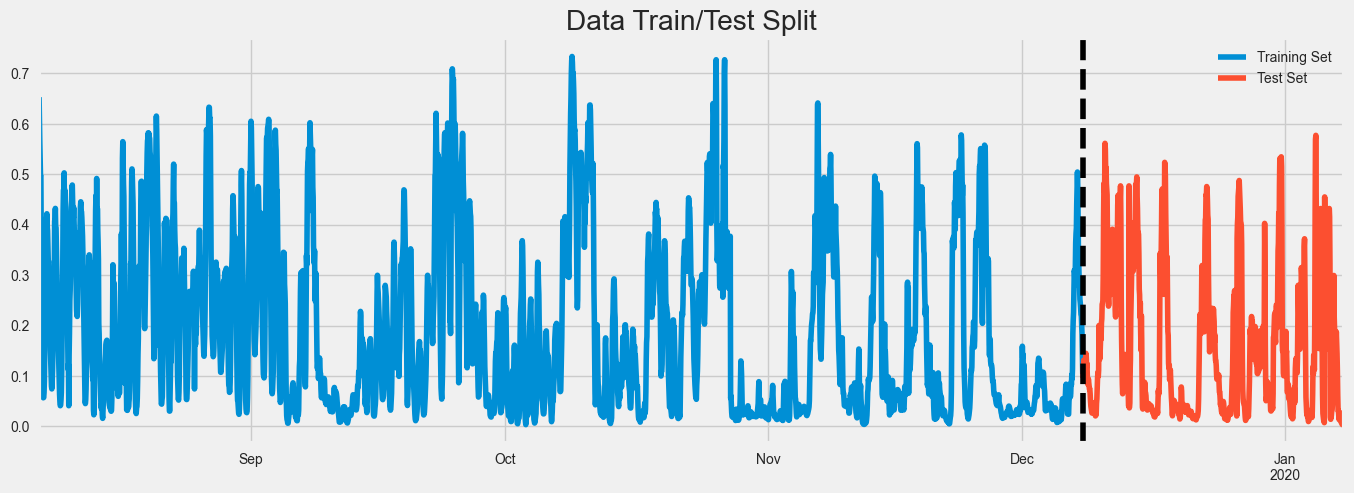

In [642]:
# 80/20 split
split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]

fig, ax = plt.subplots(figsize=(15, 5))
train[response_var].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[response_var].plot(ax=ax, label='Test Set')
ax.axvline(cutoff_date_str, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [643]:
y = df[response_var]
y.head()

2019-08-07 00:00:00    0.652524
2019-08-07 01:00:00    0.605852
2019-08-07 02:00:00    0.564094
2019-08-07 03:00:00    0.532721
2019-08-07 04:00:00    0.495608
Freq: H, Name: CF, dtype: float64

In [644]:
X = df.drop(columns=[response_var], axis=1)
X.head()

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2019-08-07 00:00:00                       0.650762   0.0        2.0      3.0   
2019-08-07 01:00:00                       0.606949   1.0        2.0      3.0   
2019-08-07 02:00:00                       0.569131   2.0        2.0      3.0   
2019-08-07 03:00:00                       0.542365   3.0        2.0      3.0   
2019-08-07 04:00:00                       0.490843   4.0        2.0      3.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 01:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 02:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 03:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 04:00:00    8.0  2019.0      219.0         7.0        32.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                           0                          0   
2019-08-07 01:00:00                           0                          0   
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                       0                            0   
2019-08-07 01:00:00                       0                            0   
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                          0                          0  
2019-08-07 01:00:00                          0                          0  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0

## Model Training and Testing

Will start out with a baseline model of AutoARIMA.

In [645]:
print(y.dtypes)
y.head()

2019-08-07 00:00:00    0.652524
2019-08-07 01:00:00    0.605852
2019-08-07 02:00:00    0.564094
2019-08-07 03:00:00    0.532721
2019-08-07 04:00:00    0.495608
Freq: H, Name: CF, dtype: float64

In [646]:
print(X.dtypes)
X.head()


prediction_wind_decision_tree  hour  dayofweek  quarter  \
2019-08-07 00:00:00                       0.650762   0.0        2.0      3.0   
2019-08-07 01:00:00                       0.606949   1.0        2.0      3.0   
2019-08-07 02:00:00                       0.569131   2.0        2.0      3.0   
2019-08-07 03:00:00                       0.542365   3.0        2.0      3.0   
2019-08-07 04:00:00                       0.490843   4.0        2.0      3.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 01:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 02:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 03:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 04:00:00    8.0  2019.0      219.0         7.0        32.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                           0                          0   
2019-08-07 01:00:00                           0                          0   
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                       0                            0   
2019-08-07 01:00:00                       0                            0   
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                          0                          0  
2019-08-07 01:00:00                          0                          0  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0

In [647]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split
# obs = 24*7 # next week of data

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2019-11-30 12:00:00', '2019-11-30 13:00:00',
               '2019-11-30 14:00:00', '2019-11-30 15:00:00',
               '2019-11-30 16:00:00', '2019-11-30 17:00:00',
               '2019-11-30 18:00:00', '2019-11-30 19:00:00',
               '2019-11-30 20:00:00', '2019-11-30 21:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=924, freq='H', is_relative=False)

In [648]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_test)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

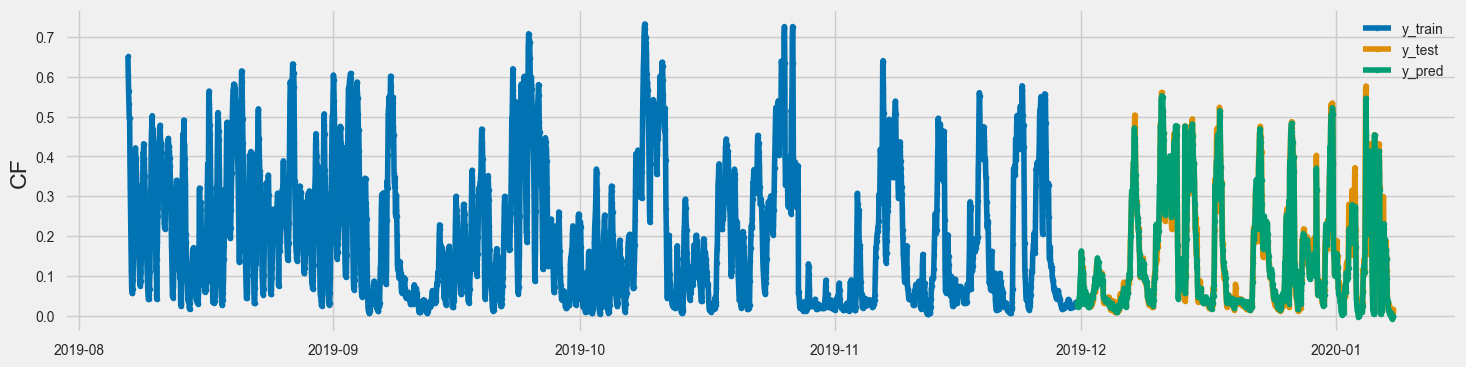

In [649]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Test Set):", mae)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

This model performs pretty well. Let's see if we can improve by cross validating with other models and optimizing hyperparameters of said models.

(Parameter estimation)

In [650]:
from sktime.registry import all_estimators
estimators = all_estimators(estimator_types="forecaster", return_names=False)

# Filter forecasters that support exogenous data
compatible_forecasters = [est for est in estimators if est.get_class_tag("scitype:y") == "both"]
print("Compatible Forecasters:", [est.__name__ for est in compatible_forecasters])


In [651]:
from sktime.registry import all_estimators
all_estimators(
    estimator_types="forecaster",
    filter_tags={
        'scitype:y': 'univariate',# target variable: 1 time series
        # 'scitype:exogenous': ['both', 'required']# takes exogenous data
        },
    as_dataframe=True
)

name  \
0                                        ARCH   
1                                        ARDL   
2                                       ARIMA   
3                                   AutoARIMA   
4                                     AutoETS   
5                      AutoEnsembleForecaster   
6                                     AutoREG   
7                                        BATS   
8                              CINNForecaster   
9                          ConformalIntervals   
10                                    Croston   
11                         CurveFitForecaster   
12          DirRecTabularRegressionForecaster   
13       DirRecTimeSeriesRegressionForecaster   
14                  DirectReductionForecaster   
15          DirectTabularRegressionForecaster   
16       DirectTimeSeriesRegressionForecaster   
17                                 DontUpdate   
18                       ExponentialSmoothing   
19                        HCrystalBallAdapter   
20                   HFTransformersForecaster   
21                                    IgnoreX   
22     MultioutputTabularRegressionForecaster   
23  MultioutputTimeSeriesRegressionForecaster   
24                            NaiveForecaster   
25                              NaiveVariance   
26                         NeuralForecastLSTM   
27                          NeuralForecastRNN   
28                   OnlineEnsembleForecaster   
29                  PolynomialTrendForecaster   
30                                    Prophet   
31      ProphetPiecewiseLinearTrendForecaster   
32                            PyKANForecaster   
33                       ReconcilerForecaster   
34       RecursiveTabularRegressionForecaster   
35    RecursiveTimeSeriesRegressionForecaster   
36                                    SARIMAX   
37                              STLForecaster   
38                          SquaringResiduals   
39                         StackingForecaster   
40                          StatsForecastARCH   
41                     StatsForecastAutoARIMA   
42                       StatsForecastAutoCES   
43                       StatsForecastAutoETS   
44                     StatsForecastAutoTBATS   
45                     StatsForecastAutoTheta   
46                         StatsForecastGARCH   
47                          StatsForecastMSTL   
48                           StatsModelsARIMA   
49                                      TBATS   
50                            ThetaForecaster   
51                     ThetaModularForecaster   
52                            TrendForecaster   
53                       UnobservedComponents   
54                                UpdateEvery   
55                          UpdateRefitsEvery   
56                                     YfromX   

                                               object  
0       <class 'sktime.forecasting.arch._uarch.ARCH'>  
1              <class 'sktime.forecasting.ardl.ARDL'>  
2   <class 'sktime.forecasting.arima._pmdarima.ARI...  
3   <class 'sktime.forecasting.arima._pmdarima.Aut...  
4            <class 'sktime.forecasting.ets.AutoETS'>  
5   <class 'sktime.forecasting.compose._ensemble.A...  
6       <class 'sktime.forecasting.auto_reg.AutoREG'>  
7              <class 'sktime.forecasting.bats.BATS'>  
8   <class 'sktime.forecasting.conditional_inverti...  
9   <class 'sktime.forecasting.conformal.Conformal...  
10       <class 'sktime.forecasting.croston.Croston'>  
11  <class 'sktime.forecasting.trend._curve_fit_fo...  
12  <class 'sktime.forecasting.compose._reduce.Dir...  
13  <class 'sktime.forecasting.compose._reduce.Dir...  
14  <class 'sktime.forecasting.compose._reduce.Dir...  
15  <class 'sktime.forecasting.compose._reduce.Dir...  
16  <class 'sktime.forecasting.compose._reduce.Dir...  
17  <class 'sktime.forecasting.stream._update.Dont...  
18  <class 'sktime.forecasting.exp_smoothing.Expon...  
19  <class 'sktime.forecasting.adapters._hcrystalb...  
20  <class 'sktime.for

In [652]:
from sktime.forecasting.arch import ARCH
from sktime.forecasting.ardl import ARDL
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.conditional_invertible_neural_network import CINNForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.fbprophet import Prophet

In [653]:
from sktime.forecasting.var import VAR
from sktime.forecasting.bats import BATS

Building upon the train-test split section above, this is a visualization of the folds in the Time series cross validation. 

In [654]:
### Temporal cross-validation

# This is splitting the time series iteratively.
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils import plot_windows

obs = 24*7 # next week of data
fh = ForecastingHorizon(np.arange(obs) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True)

In [655]:
# y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh)

# print(y_train.size)
# print(y_test.size)

# print(X_train.size)
# print(X_test.size)

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

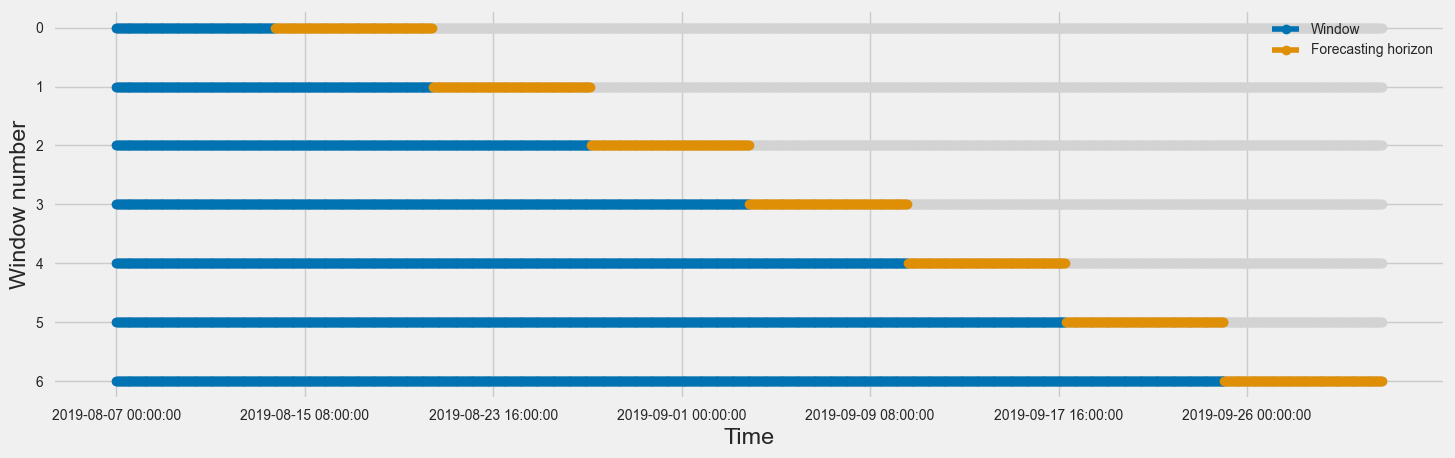

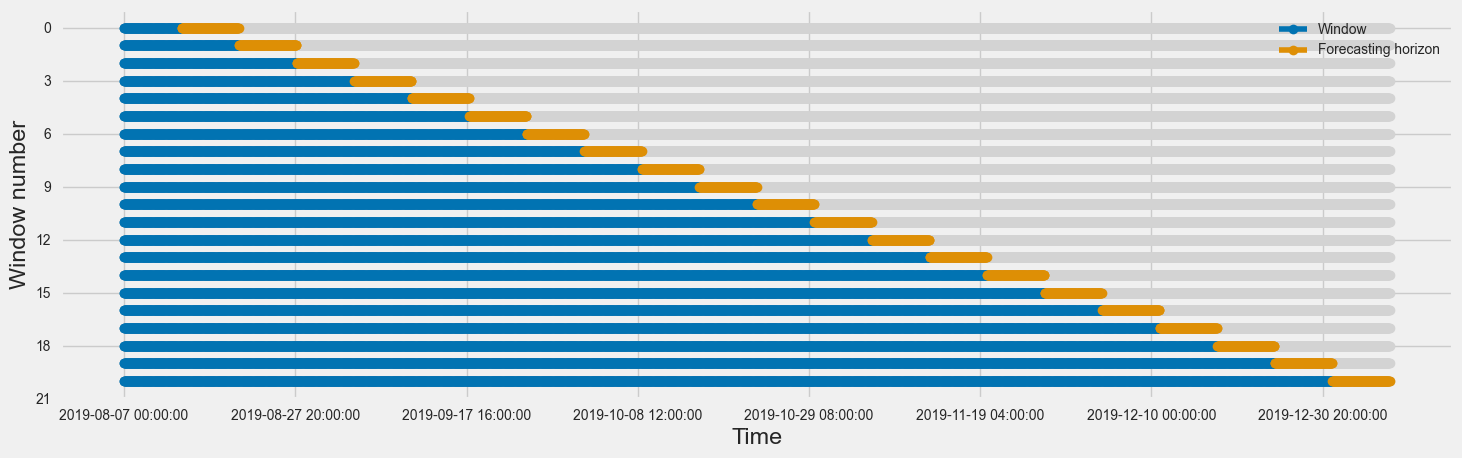

In [656]:
cv = ExpandingWindowSplitter(
    # step_length=int(obs/7),
    step_length=int(obs),
    fh=fh,
    initial_window=obs
)

plot_windows(cv, y.iloc[:obs*2*2*2])
plot_windows(cv, y)

In [657]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)

from sktime.forecasting.neuralforecast import NeuralForecastRNN
from sktime.forecasting.neuralforecast import NeuralForecastLSTM
# from sktime.regression.deep_learning.cnn import CNNRegressor
# from sktime.regression.deep_learning.rnn import SimpleRNNRegressor



forecaster = MultiplexForecaster(
    forecasters=[
        # ("arch", ARCH()),
        # ("ardl", ARDL()),
        ("arima", ARIMA()),
        ("autoarima", AutoARIMA()),
        # ("autoets", AutoETS()),
        # ("AutoEnsembleForecaster", AutoEnsembleForecaster()),
        # ("AutoREG", AutoREG()),
        # ("CINNForecaster", CINNForecaster()),
        ("exp_smoothing", ExponentialSmoothing()),
        ("poly_trend", PolynomialTrendForecaster()),
        ("prophet", Prophet()),
        # ("var", VAR()),
        # ("bats", BATS(use_box_cox=False)),# use_trend=True,
        # ("rnn", NeuralForecastRNN()),
        # ("lstm", NeuralForecastLSTM()),
        
    ]
)

# forecaster_param_grid = {"selected_forecaster": [
#     "arch", "ardl", "arima", "autoarima", "autoets", "AutoEnsembleForecaster",
#     "AutoREG", "CINNForecaster", "ExponentialSmoothing", "PolynomialTrendForecaster", "Prophet"
#     ]}

param_grid = {
    "selected_forecaster": ["arima", "autoarima",  "exp_smoothing", "poly_trend", "prophet",
                            # "var", "bats",
                            # "rnn", "lstm",
                            ],
    "arima__order": [(1, 1, 1), (2, 1, 0)],
    "autoarima__sp": [None, 7*24, 1*24], # hourly data: 30ish*24 is monthly, 7*24 is weekly, 1*24 is daily
    # "autoets__automatic": [True, False],
    "exp_smoothing__trend": ["add", "mul"],
    "poly_trend__degree": [1, 2, 3],
    # "prophet__yearly_seasonality": [True, False],
    "prophet__yearly_seasonality": [True, False],
    # "bats__use_trend": [True, False],
    
}

gscv = ForecastingGridSearchCV(forecaster=forecaster, cv=cv, param_grid=param_grid)
gscv


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [658]:
gscv.fit(y=y_train, X=X_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [659]:
print(gscv.best_params_)
gscv.best_params_

{'arima__order': (1, 1, 1),
 'autoarima__sp': None,
 'exp_smoothing__trend': 'add',
 'poly_trend__degree': 1,
 'prophet__yearly_seasonality': True,
 'selected_forecaster': 'autoarima'}

In [660]:
print(gscv.best_score_)
gscv.best_score_

0.15933831133436677

In [661]:
gscv

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [662]:
print(len(X_test))
print(len(fh)) # IF YOU SET UP FH PROPERLY IN THE CROSS VALIDATION, THESE WILL BOTH BE 168 ie. 1 week (OR WHATEVER NUMBER YOU END UP BEING THE WINDOW SIZE)


In [663]:
len(X_test)

924

In [664]:
len(fh)

168

In [665]:
# make sure we are predicting on a fh for the whole X_test set
# otherwise - this error: ValueError: X array dims (n_rows) != n_periods. Received n_rows=169 and n_periods=168
# n_rows is size of X_test, n_periods is size of fh
fh = ForecastingHorizon(np.arange(len(X_test)) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       915, 916, 917, 918, 919, 920, 921, 922, 923, 924],
      dtype='int32', length=924, is_relative=True)

In [666]:
assert len(fh) == len(X_test)

In [667]:
y_pred = gscv.predict(fh, X=X_test) # this tries out all of the parameter combinations, generates predictions, evaluates them, and picks the best one/set


In [668]:
print(gscv.get_fitted_params()) # result of Parameter estimation

In [669]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Test Set):", mae)


It appears that the AutoARIMA model performed the best.

I will also mention that the MAE on the test set increased using this time series cross validation method, compared to when the original train/test split with a cutoff date was used. (This makes sense, as the cross validation method will be less likely to overfit)

## Output: MAE (Test Set)

Using the optimized AutoARIMA model and the inital train/test split, let's see the MAE:

In [670]:
print("MAE (Test Set):", mae)
# print("MAE (Average of Test Sets in Time series cross validation):", mae)
mae

0.014009427682971547

## Plot: Predictions vs. Actuals (Test Set)

For this visualization, I will use the train/test split.



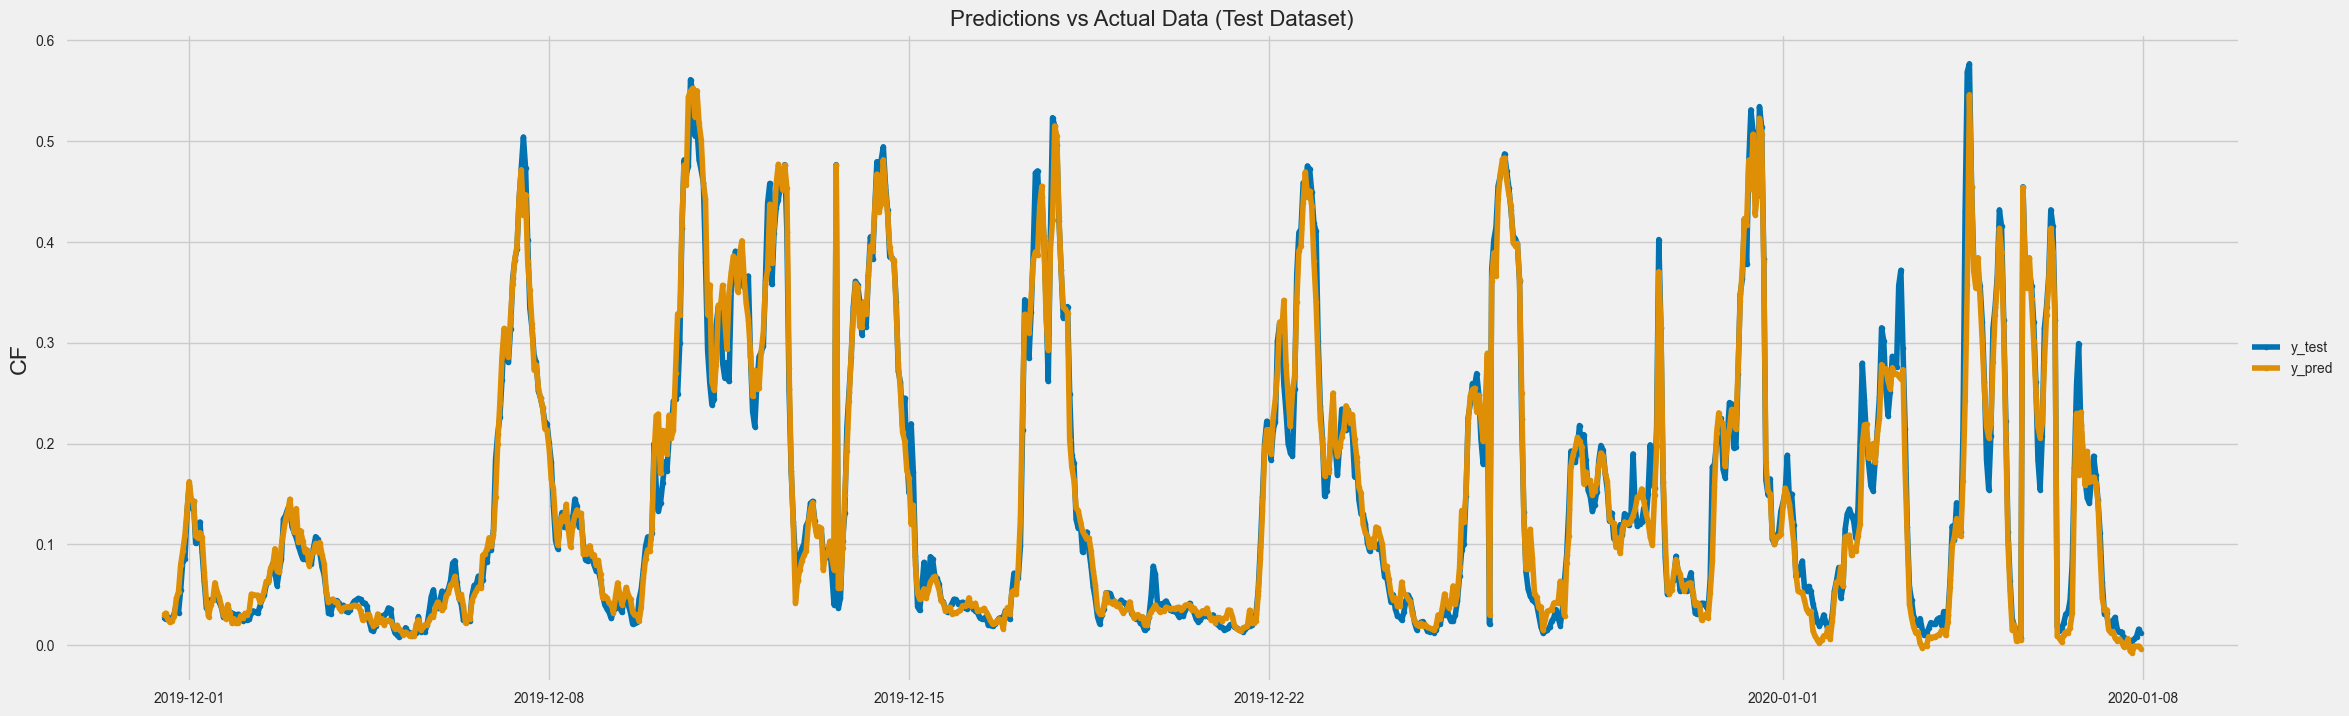

In [671]:
fig, ax = plot_series(
    # y_train,
    y_test,
    y_pred,
    labels=[
        # 'y_train',
        'y_test',
        'y_pred',
    ]
    )

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title('Predictions vs Actual Data (Test Dataset)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

To visualize the model performance during cross-validation, I will also look at each iteration of the time series cross validation, and compare that to the actual values.
- This is done via prediction data using `ExpandingWindowSplitter()` and `evaluate()` with an AutoARIMA and forecasting window sizes of 7*24=168. (1 week)

In [672]:
obs = 24*7 # next week of data
fh = ForecastingHorizon(np.arange(obs) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True)

In [673]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh)

print(y_train.size)
print(y_test.size)

print(X_train.size)
print(X_test.size)

In [674]:
print(gscv.get_fitted_params())

In [675]:
gscv.get_fitted_params()

{'forecaster': AutoARIMA(sp=None),
 'prediction_wind_decision_tree': 1.0103115482777587,
 'hour': -0.0001549194249578091,
 'dayofweek': -0.0006974753778033599,
 'quarter': 0.003015646833759297,
 'month': 9.221129813614304e-05,
 'year': -6.58427010723216e-06,
 'dayofyear': -8.756568055260414e-06,
 'dayofmonth': 0.00014823327479070265,
 'weekofyear': 9.838521094085158e-05,
 'holiday_name_Christmas Day': -3.535040396894223e-18,
 'holiday_name_Columbus Day': -0.006911525542525812,
 'holiday_name_Labor Day': 0.011718119614254426,
 "holiday_name_New Year's Day": 0.0,
 'holiday_name_Thanksgiving': -0.0006383805136490597,
 'holiday_name_Veterans Day': -0.002093481315689647,
 'sigma2': 1.4719713854117642,
 'order': (0, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 6199.257587125538,
 'aicc': 6199.455046290692,
 'bic': 6294.094776890494,
 'hqic': 6233.507685411528,
 'forecaster__prediction_wind_decision_tree': 1.0103115482777587,
 'forecaster__hour': -0.0001549194249578091,
 'forecaster__dayof

In [676]:
gscv.best_params_

{'arima__order': (1, 1, 1),
 'autoarima__sp': None,
 'exp_smoothing__trend': 'add',
 'poly_trend__degree': 1,
 'prophet__yearly_seasonality': True,
 'selected_forecaster': 'autoarima'}

In [677]:
# plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# answer is above
# model (AutoARIMA)
from sktime.forecasting.model_evaluation import evaluate

# forecaster = AutoARIMA(sp=7*24)
forecaster = AutoARIMA()
forecaster



AutoARIMA()

In [678]:
# from sktime.param_est.plugin import PluginParamsForecaster
best_params = gscv.best_params_

sp_value = best_params.get('autoarima__sp', None)
if sp_value:
    forecaster.set_params(sp=sp_value)



In [679]:
forecaster

AutoARIMA()

In [680]:
# pipeline = PluginParamsForecaster(param_est=gscv, forecaster=forecaster) # finds matches in gscv that are for AutoARIMA
# VERIFY that the sp or other params we inserted into the pipeline's forecaster ie. example is sp=168 for AutoARIMA
# print(pipeline.forecaster_)
# pipeline.forecaster_

In [681]:
# how to split the model 
# (cv strategy: starts with initial_window, expands by step_length w/ each step until it encompasses all data)
# (excluding test set, which is defined by fh/forecasting horizon)
cv = ExpandingWindowSplitter(
    step_length=obs,
    fh=fh,
    initial_window=obs*2 # increasing initial window to 2 weeks, remove error where 1st model predictions were NA
    # this error occured because the optimal sp/period for seasonal differencing is 168, so needed more data
)

# results = evaluate(
#     forecaster=forecaster,
#     y=y,
#     X=X,
#     cv=cv,
#     strategy="refit", # model is refitted to each training set derived during cv process
#     return_data=True # returns the prediction data
# )

# results = evaluate(
#     forecaster=pipeline, y=y, X=X, cv=cv, strategy="refit", return_data=True 
# )
results = evaluate(
    forecaster=forecaster, y=y, X=X, cv=cv, strategy="refit", return_data=True 
)




In [682]:
# results.iloc[:, :5]#.head() # this cuts off last 3 cols ie. y_train/y_test/y_pred

In [683]:
results

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                           0.099664  0.338557   0.031532               336   
1                           0.096094  0.474767   0.025856               504   
2                           0.256156  1.023479   0.035842               672   
3                           0.245486  0.476456   0.028425               840   
4                           0.123257  0.650753   0.028768              1008   
5                           0.161830  0.635153   0.027698              1176   
6                           0.174759  0.818953   0.037096              1344   
7                           0.141238  0.783192   0.034307              1512   
8                           0.131497  1.034951   0.027933              1680   
9                           0.135169  1.163115   0.031186              1848   
10                          0.225230  1.388371   0.029811              2016   
11                          0.175563  1.556204   0.032432              2184   
12                          0.120263  1.349570   0.031125              2352   
13                          0.156641  1.358597   0.027710              2520   
14                          0.144564  1.478215   0.030192              2688   
15                          0.166135  1.340247   0.037843              2856   
16                          0.108708  1.358239   0.026169              3024   
17                          0.152655  1.452425   0.028580              3192   
18                          0.187741  1.507864   0.030447              3360   
19                          0.225291  1.693956   0.031465              3528   

                cutoff                                            y_train  \
0  2019-08-20 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
1  2019-08-27 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
2  2019-09-03 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
3  2019-09-10 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
4  2019-09-17 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
5  2019-09-24 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
6  2019-10-01 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
7  2019-10-08 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
8  2019-10-15 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
9  2019-10-22 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
10 2019-10-29 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
11 2019-11-05 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
12 2019-11-12 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
13 2019-11-19 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
14 2019-11-26 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
15 2019-12-03 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
16 2019-12-10 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
17 2019-12-17 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
18 2019-12-24 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
19 2019-12-31 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   

                                               y_test  \
0   2019-08-21 00:00:00    0.434057
2019-08-21 01:...   
1   2019-08-28 00:00:00    0.308110
2019-08-28 01:...   
2   2019-09-04 00:00:00    0.507541
2019-09-04 01:...   
3   2019-09-11 00:00:00    0.069512
2019-09-11 01:...   
4   2019-09-18 00:00:00    0.235803
2019-09-18 01:...   
5   2019-09-25 00:00:00    0.582406
2019-09-25 01:...   
6   2019-10-02 00:00:00    0.115158
2019-10-02 01:...   
7   2019-10-09 00:00:00    0.700745
2019-10-09 01:...   
8   2019-10-16 00:00:00    0.176474
2019-10-16 01:...   
9   2019-10-23 00:00:00    0.282829
2019-10-23 01:...   
10  2019-10-30 00:00:00    0.028512
2019-10-30 01:...   
11  2019-11-06 00:00:00    0.171021
2019-1

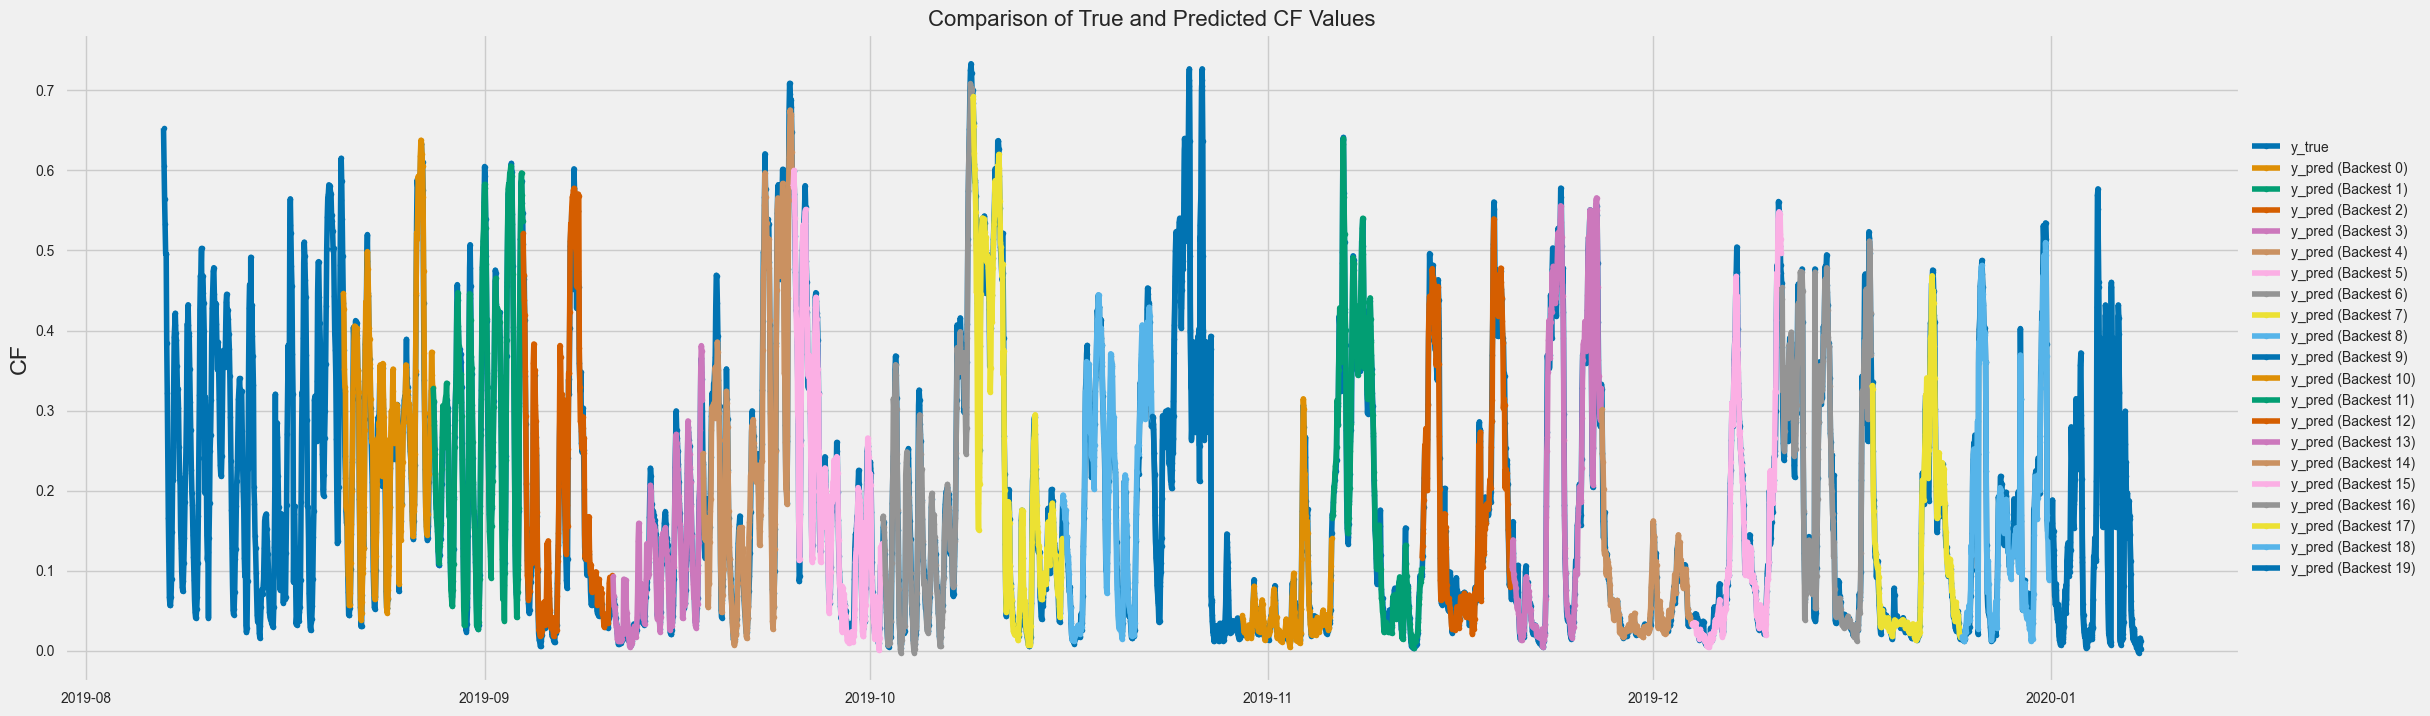

In [684]:
fig, ax = plot_series(
    y,
    results['y_pred'].iloc[0],
    results['y_pred'].iloc[1],
    results['y_pred'].iloc[2],
    results['y_pred'].iloc[3],
    results['y_pred'].iloc[4],
    results['y_pred'].iloc[5],
    results['y_pred'].iloc[6],
    results['y_pred'].iloc[7],
    results['y_pred'].iloc[8],
    results['y_pred'].iloc[9],
    results['y_pred'].iloc[10],
    results['y_pred'].iloc[11],
    results['y_pred'].iloc[12],
    results['y_pred'].iloc[13],
    results['y_pred'].iloc[14],
    results['y_pred'].iloc[15],
    results['y_pred'].iloc[16],
    results['y_pred'].iloc[17],
    results['y_pred'].iloc[18],
    results['y_pred'].iloc[19],
    # results['y_pred'].iloc[20],
    
    
    labels=["y_true"] + ["y_pred (Backest " + str(x) + ")" for x in range(0, (20))]# ["y_pred (Backest " + str(x) + ")" for x in range(1 + 5)]
    
)
fig.set_size_inches(25, 8)  # Change the figure size to 15 inches wide by 8 inches tall

ax.set_title('Comparison of True and Predicted CF Values', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()  # Display the plot

The average error is solid, and the prediction overall tend to be right on top of the actuals!

What happened here:
- Started with a window of 2 weeks (24 hours in a day * 7 days per week) of observations [Blue lines at start]
- Trained an algorithm and made predictions on the next 1 week [Orange line at start]
- Compared that to the actual data
- Moved 1 week ahead
- Updated algorithm with the new window size of 3 weeks
- Re-trained algorithm, made predictions on the next 1 week
- Updated algorithm with the new window size of 4 weeks
- Re-trained algorithm, made predictions on the next 1 week
- Process continues! (Until we reach the end of the time series ie. have no data to compare our prediction to)

## Making Predictions (on 'Predict' Sheet from input Excel file)

Now that we are making prediction on new/unseen data that we cannot compare the results with (since it is in the future), I will re-train the model using ALL data I have available to me, and then make the predictions!

In [685]:
df_test = test_data.copy()
print(df_test.shape)
df_test = ensure_hourly_frequency(df=df_test)

df_test.head()


CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [686]:
# Get predictions from decision tree with wind 
X_predict_wind = df_test.drop(response_var, axis=1)
print(X_predict_wind.shape)
X_predict_wind.index.freq = 'H'
print(X_predict_wind.index.dtype)

In [687]:
model = load_model(os.path.join(INTER_DIR, "optimal_model"))
model

Pipeline(memory=FastMemory(location=C:\Users\Myles\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                             'WS_1156968', 'WS_1182195',
                                             'WS_1193865', 'WS_1321569',
                                             'WS_1324653', 'WS_1358699',
                                             'WS_1366338', 'WS_1366351',
                                             'WS_1369320', 'WS_1461024',
                                             'WS_1481513', 'WS_1504146',
                                             'WS_1513782', 'WS_1513805',
                                             'WS_1571...
                                             'WS_1628663', 'WS_1681085',
                                             'WS_1820276', 'WS_1820279',
                                             'WS_1899876', 'WS_1911282',
                                             'WS_1937650', 'WS_1937653',
                                             'WS_1953863', 'WS_1960535', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x00000113A7773950>)])

In [688]:
X_predict_CF = pd.DataFrame(
    {'prediction_wind_decision_tree': model.predict(X_predict_wind)},
    index=X_predict_wind.index
)
X_predict_CF

prediction_wind_decision_tree
2020-01-09 00:00:00                       0.008983
2020-01-09 01:00:00                       0.010315
2020-01-09 02:00:00                       0.020462
2020-01-09 03:00:00                       0.017877
2020-01-09 04:00:00                       0.011432
...                                            ...
2020-01-12 16:00:00                       0.031773
2020-01-12 17:00:00                       0.031321
2020-01-12 18:00:00                       0.030263
2020-01-12 19:00:00                       0.033729
2020-01-12 20:00:00                       0.030396

[93 rows x 1 columns]

In [689]:
# Further pre-processing
X_predict_CF = create_features(X_predict_CF)
X_predict_CF = pd.get_dummies(X_predict_CF)
del X_predict_CF['is_holiday']

holidays_list = [
    'holiday_name_Christmas Day',
    'holiday_name_Columbus Day',
    'holiday_name_Labor Day',
    "holiday_name_New Year's Day",
    "holiday_name_Thanksgiving",
    "holiday_name_Veterans Day",
]
for holiday in holidays_list:
    if holiday not in set(X_predict_CF.columns):
        X_predict_CF[holiday] = 0

X_predict_CF = prepare_data_for_sktime(X_predict_CF)
print(X_predict_CF.dtypes)

print(len(set(X_predict_CF.columns)))
print(len(set(X.columns)))
assert set(X_predict_CF.columns) == set(X.columns)

Normally, we would be done preparing this dataset for predictions. But, given that there is a gap of 1 day between the training set and the predict set, I will have to fill this missing data. (We need data leading up to the prediction set so that the ARIMA model can make predictions)

Note: The reason why I initially was getting the following error is because I did not notice this 1 day gap between train dat and predict data:

"sktime: ValueError: X array dims (n_rows) != n_periods. Received n_rows=93 and n_periods=117"

In [690]:
# Join together train/predict
df_joined = pd.concat(
    objs=[df, X_predict_CF]
)

df_joined = ensure_hourly_frequency(df=df_joined)
del df_joined['CF']
cutoff_date_str = df_joined.tail(117).index[0]
print(f"cutoff_date_str: {cutoff_date_str}")
df_joined.tail(117)

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2020-01-08 00:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 01:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 02:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 03:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 04:00:00                            NaN   NaN        NaN      NaN   
...                                            ...   ...        ...      ...   
2020-01-12 16:00:00                       0.031773  16.0        6.0      1.0   
2020-01-12 17:00:00                       0.031321  17.0        6.0      1.0   
2020-01-12 18:00:00                       0.030263  18.0        6.0      1.0   
2020-01-12 19:00:00                       0.033729  19.0        6.0      1.0   
2020-01-12 20:00:00                       0.030396  20.0        6.0      1.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2020-01-08 00:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 01:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 02:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 03:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 04:00:00    NaN     NaN        NaN         NaN         NaN   
...                    ...     ...        ...         ...         ...   
2020-01-12 16:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 17:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 18:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 19:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 20:00:00    1.0  2020.0       12.0        12.0         2.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-08 00:00:00                         NaN                        NaN   
2020-01-08 01:00:00                         NaN                        NaN   
2020-01-08 02:00:00                         NaN                        NaN   
2020-01-08 03:00:00                         NaN                        NaN   
2020-01-08 04:00:00                         NaN                        NaN   
...                                         ...                        ...   
2020-01-12 16:00:00                         0.0                        0.0   
2020-01-12 17:00:00                         0.0                        0.0   
2020-01-12 18:00:00                         0.0                        0.0   
2020-01-12 19:00:00                         0.0                        0.0   
2020-01-12 20:00:00                         0.0                        0.0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-08 00:00:00                     NaN                          NaN   
2020-01-08 01:00:00                     NaN                          NaN   
2020-01-08 02:00:00                     NaN                          NaN   
2020-01-08 03:00:00                     NaN                          NaN   
2020-01-08 04:00:00                     NaN                          NaN   
...                                     ...                          ...   
2020-01-12 16:00:00                     0.0                          0.0   
2020-01-12 17:00:00                     0.0                          0.0   
2020-01-12 18:00:00                     0.0                          0.0   
2020-01-12 19:00:00                     0.0                          0.0   
2020-01-12 20:00:00                     0.0                          0.0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-08 00:00:00                        NaN                        NaN  
2020-01-08 01:00:00                        NaN                        NaN  
2020-01-08 02:00:00                        NaN                        NaN  
2020-01-08 03:00:00          

Once again, we just introduced NA into our dataset. Because we do not have prediction data for wind model for these 24 hours of data, we are going to have to forward fill the values from the wind prediction model in the training dataset.

Because of the weekly trend, I will use a similar strategy as before, and simply take the values from last day at this same exact time.

In [691]:
print(df_joined.isna().sum())

In [692]:
df_joined = custom_ffill(df_joined, list(df_joined.columns), 24)

In [693]:
print(df_joined.isna().sum())

Now that the forward filling is done, we can drop the data from the training set.

In [694]:
# df_joined = df_joined.tail(93+24)
req_cutoff_date_str = (df_joined.index >= cutoff_date_str)
df_joined = df_joined[req_cutoff_date_str]

assert df_joined.shape[0] == 117

df_joined

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2020-01-08 00:00:00                       0.170722   0.0        1.0      1.0   
2020-01-08 01:00:00                       0.174752   1.0        1.0      1.0   
2020-01-08 02:00:00                       0.169528   2.0        1.0      1.0   
2020-01-08 03:00:00                       0.151090   3.0        1.0      1.0   
2020-01-08 04:00:00                       0.101109   4.0        1.0      1.0   
...                                            ...   ...        ...      ...   
2020-01-12 16:00:00                       0.031773  16.0        6.0      1.0   
2020-01-12 17:00:00                       0.031321  17.0        6.0      1.0   
2020-01-12 18:00:00                       0.030263  18.0        6.0      1.0   
2020-01-12 19:00:00                       0.033729  19.0        6.0      1.0   
2020-01-12 20:00:00                       0.030396  20.0        6.0      1.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2020-01-08 00:00:00    1.0  2020.0        7.0         7.0         2.0   
2020-01-08 01:00:00    1.0  2020.0        7.0         7.0         2.0   
2020-01-08 02:00:00    1.0  2020.0        7.0         7.0         2.0   
2020-01-08 03:00:00    1.0  2020.0        7.0         7.0         2.0   
2020-01-08 04:00:00    1.0  2020.0        7.0         7.0         2.0   
...                    ...     ...        ...         ...         ...   
2020-01-12 16:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 17:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 18:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 19:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 20:00:00    1.0  2020.0       12.0        12.0         2.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-08 00:00:00                         0.0                        0.0   
2020-01-08 01:00:00                         0.0                        0.0   
2020-01-08 02:00:00                         0.0                        0.0   
2020-01-08 03:00:00                         0.0                        0.0   
2020-01-08 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2020-01-12 16:00:00                         0.0                        0.0   
2020-01-12 17:00:00                         0.0                        0.0   
2020-01-12 18:00:00                         0.0                        0.0   
2020-01-12 19:00:00                         0.0                        0.0   
2020-01-12 20:00:00                         0.0                        0.0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-08 00:00:00                     0.0                          0.0   
2020-01-08 01:00:00                     0.0                          0.0   
2020-01-08 02:00:00                     0.0                          0.0   
2020-01-08 03:00:00                     0.0                          0.0   
2020-01-08 04:00:00                     0.0                          0.0   
...                                     ...                          ...   
2020-01-12 16:00:00                     0.0                          0.0   
2020-01-12 17:00:00                     0.0                          0.0   
2020-01-12 18:00:00                     0.0                          0.0   
2020-01-12 19:00:00                     0.0                          0.0   
2020-01-12 20:00:00                     0.0                          0.0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-08 00:00:00                        0.0                        0.0  
2020-01-08 01:00:00                        0.0                        0.0  
2020-01-08 02:00:00                        0.0                        0.0  
2020-01-08 03:00:00          



The columns of data regarding the date (day of week, holidays, etc.) do not need to be forward filled. Let's make sure those are correct:

In [695]:
# Further pre-processing
df_joined = create_features(df_joined)
df_joined = pd.get_dummies(df_joined)
del df_joined['is_holiday']

holidays_list = [
    'holiday_name_Christmas Day',
    'holiday_name_Columbus Day',
    'holiday_name_Labor Day',
    "holiday_name_New Year's Day",
    "holiday_name_Thanksgiving",
    "holiday_name_Veterans Day",
]
for holiday in holidays_list:
    if holiday not in set(df_joined.columns):
        df_joined[holiday] = 0

df_joined = prepare_data_for_sktime(df_joined)
print(df_joined.dtypes)

print(len(set(df_joined.columns)))
print(len(set(X.columns)))
assert set(df_joined.columns) == set(X.columns)


In [696]:
df_joined

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2020-01-08 00:00:00                       0.170722     0          2        1   
2020-01-08 01:00:00                       0.174752     1          2        1   
2020-01-08 02:00:00                       0.169528     2          2        1   
2020-01-08 03:00:00                       0.151090     3          2        1   
2020-01-08 04:00:00                       0.101109     4          2        1   
...                                            ...   ...        ...      ...   
2020-01-12 16:00:00                       0.031773    16          6        1   
2020-01-12 17:00:00                       0.031321    17          6        1   
2020-01-12 18:00:00                       0.030263    18          6        1   
2020-01-12 19:00:00                       0.033729    19          6        1   
2020-01-12 20:00:00                       0.030396    20          6        1   

                     month  year  dayofyear  dayofmonth  weekofyear  \
2020-01-08 00:00:00      1  2020          8           8         2.0   
2020-01-08 01:00:00      1  2020          8           8         2.0   
2020-01-08 02:00:00      1  2020          8           8         2.0   
2020-01-08 03:00:00      1  2020          8           8         2.0   
2020-01-08 04:00:00      1  2020          8           8         2.0   
...                    ...   ...        ...         ...         ...   
2020-01-12 16:00:00      1  2020         12          12         2.0   
2020-01-12 17:00:00      1  2020         12          12         2.0   
2020-01-12 18:00:00      1  2020         12          12         2.0   
2020-01-12 19:00:00      1  2020         12          12         2.0   
2020-01-12 20:00:00      1  2020         12          12         2.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-08 00:00:00                         0.0                        0.0   
2020-01-08 01:00:00                         0.0                        0.0   
2020-01-08 02:00:00                         0.0                        0.0   
2020-01-08 03:00:00                         0.0                        0.0   
2020-01-08 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2020-01-12 16:00:00                         0.0                        0.0   
2020-01-12 17:00:00                         0.0                        0.0   
2020-01-12 18:00:00                         0.0                        0.0   
2020-01-12 19:00:00                         0.0                        0.0   
2020-01-12 20:00:00                         0.0                        0.0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-08 00:00:00                     0.0                          0.0   
2020-01-08 01:00:00                     0.0                          0.0   
2020-01-08 02:00:00                     0.0                          0.0   
2020-01-08 03:00:00                     0.0                          0.0   
2020-01-08 04:00:00                     0.0                          0.0   
...                                     ...                          ...   
2020-01-12 16:00:00                     0.0                          0.0   
2020-01-12 17:00:00                     0.0                          0.0   
2020-01-12 18:00:00                     0.0                          0.0   
2020-01-12 19:00:00                     0.0                          0.0   
2020-01-12 20:00:00                     0.0                          0.0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-08 00:00:00                        0.0                        0.0  
2020-01-08 01:00:00                        0.0                        0.0  
2020-01-08 02:00:00                        0.0                        0.0  
2020-01-08 03:00:00                        0.0       

Now that the data has been feature engineered like the training set, we can setup the forecasting horizon.

In [697]:
# y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)
y_train = df[response_var]
y_test = None
X_train = df.drop(response_var, axis=1)
X_test = df_joined.copy()
print(X_test.index.min())

fh = ForecastingHorizon(X_test.index, is_relative=False)
print(fh.min())
print(len(fh))
# fh = ForecastingHorizon(len(X_test.index), is_relative=False) # either of these will have code run, but 1 is wrong
# print(fh.min())

fh

ForecastingHorizon(['2020-01-08 00:00:00', '2020-01-08 01:00:00',
               '2020-01-08 02:00:00', '2020-01-08 03:00:00',
               '2020-01-08 04:00:00', '2020-01-08 05:00:00',
               '2020-01-08 06:00:00', '2020-01-08 07:00:00',
               '2020-01-08 08:00:00', '2020-01-08 09:00:00',
               ...
               '2020-01-12 11:00:00', '2020-01-12 12:00:00',
               '2020-01-12 13:00:00', '2020-01-12 14:00:00',
               '2020-01-12 15:00:00', '2020-01-12 16:00:00',
               '2020-01-12 17:00:00', '2020-01-12 18:00:00',
               '2020-01-12 19:00:00', '2020-01-12 20:00:00'],
              dtype='datetime64[ns]', length=117, freq='H', is_relative=False)

In [698]:
assert X_test.index.min() == fh.min()

Important Note: There is a 1 day gap between train/predict data (train ends on 1/7/2020 at 23:00, predict starts at 1/9/2020 at 00:00), so need to ensure that we are using the indices from the predict dataframe, and not just the next 93 hourly data points.

In [699]:
print("Length of fh:", len(fh))
print("Length of X_test:", len(X_test))

In [700]:
time_diffs = X_test.index.to_series().diff().unique()
print(time_diffs)

In [701]:
print(y_train.shape)
print(X_train.shape)


In [702]:

# forecaster = AutoARIMA(sp=24*7)
# forecaster = AutoARIMA()

forecaster = AutoARIMA()
forecaster.set_params(sp=sp_value)

AutoARIMA(sp=None)

In [703]:
# forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
# pipeline.fit(y_train.tail(4000), X_train.tail(4000)) # this is fixing an error where model woulld train for hours



AutoARIMA(sp=None)

In [704]:
y_pred = forecaster.predict(fh, X=X_test)
# y_pred = pipeline.predict(fh, X=X_test)

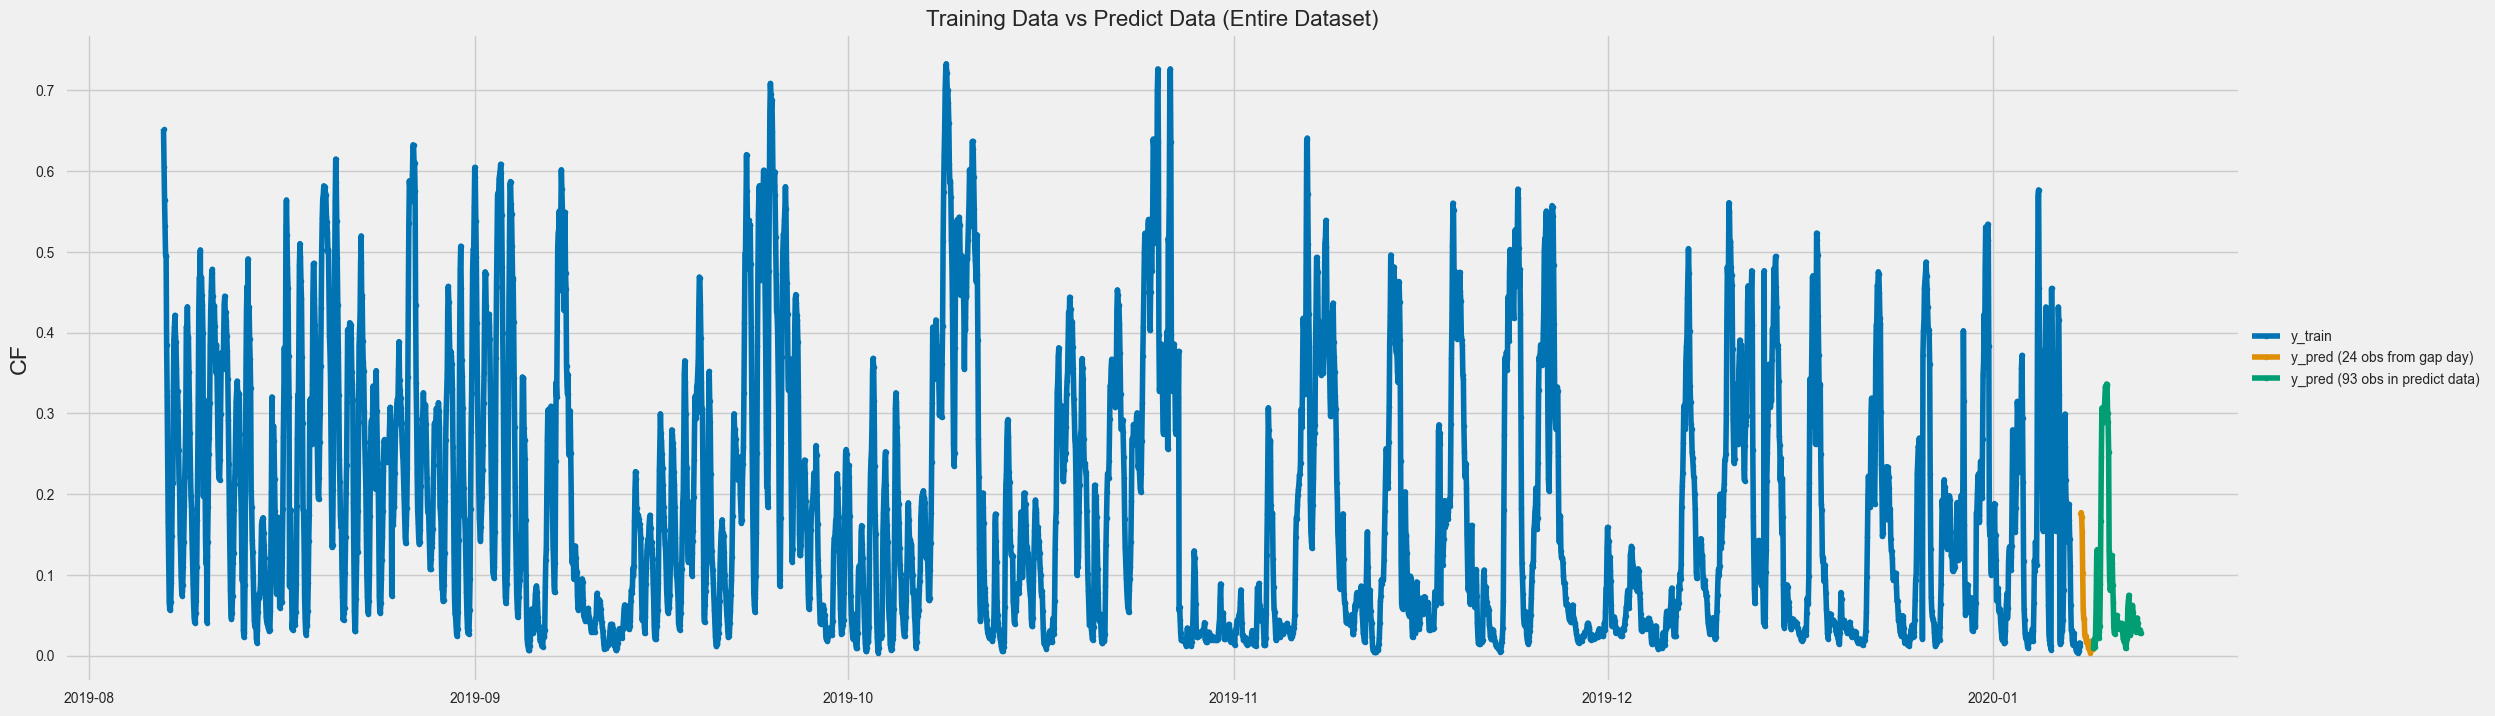

In [705]:
fig, ax = plot_series(
    y_train,
    y_pred.head(24),
    y_pred.tail(93),
    labels=[
        'y_train',
        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title('Training Data vs Predict Data (Entire Dataset)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

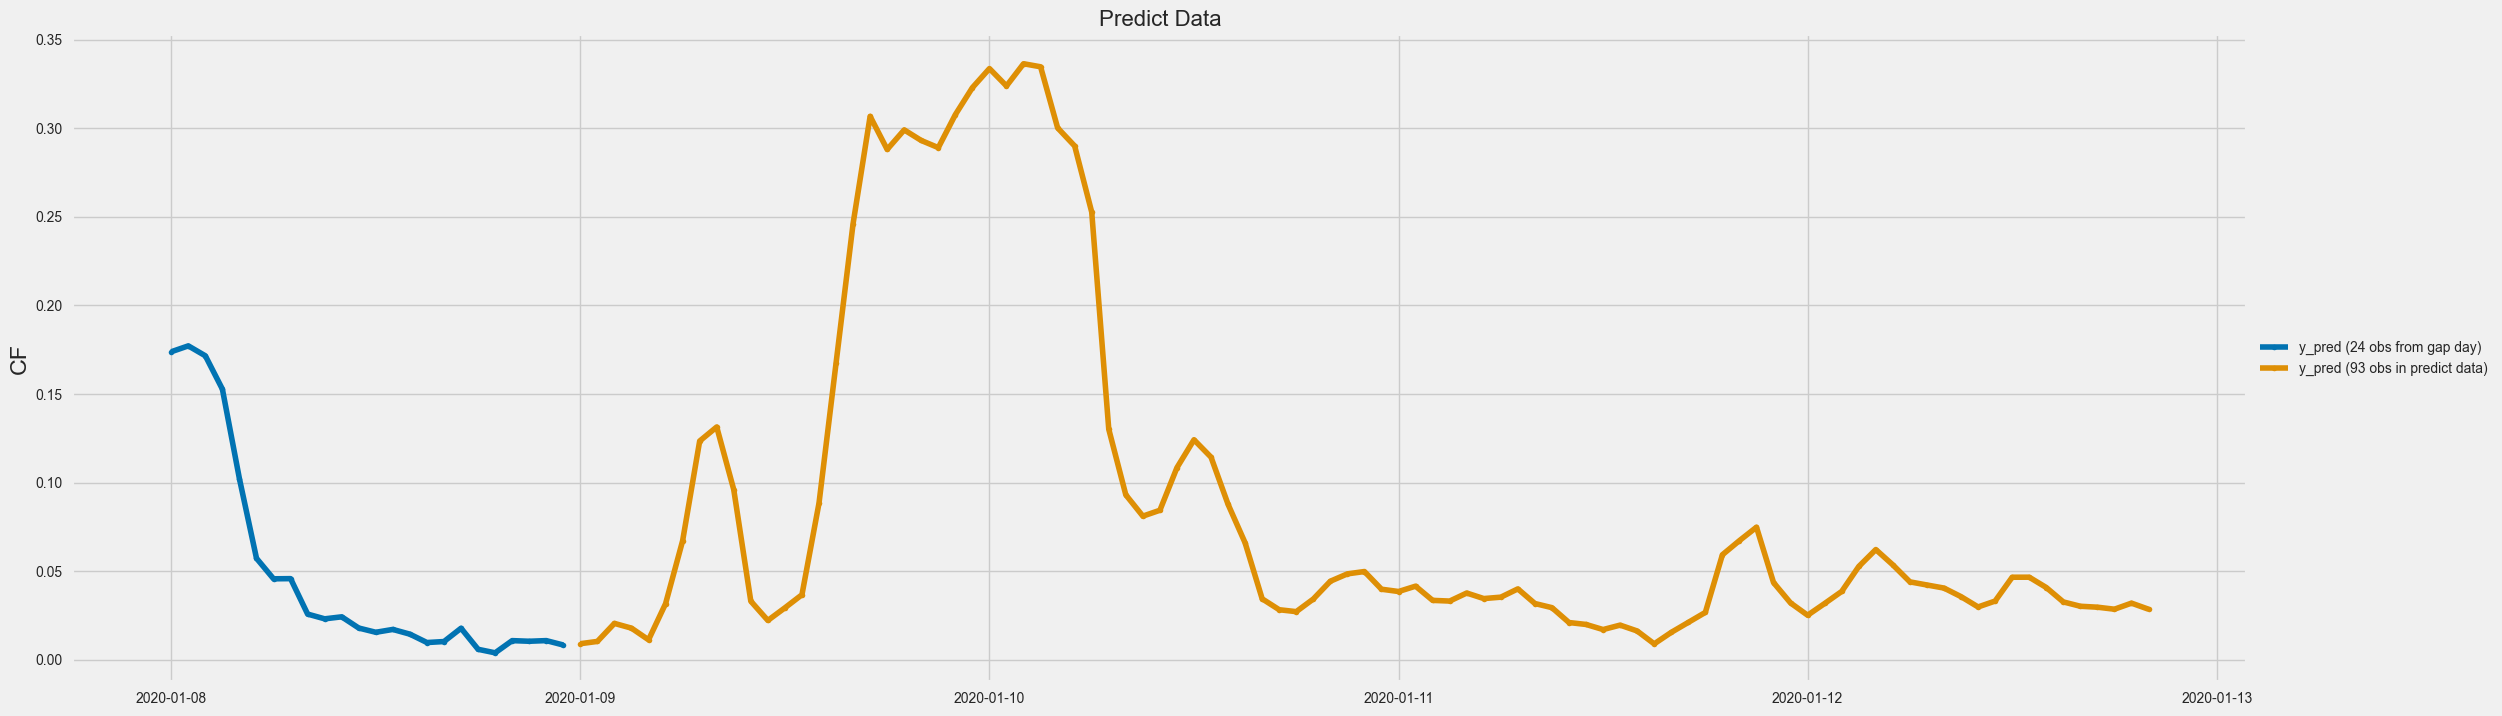

In [706]:
fig, ax = plot_series(
    y_pred.head(24),
    y_pred.tail(93),
    labels=[
        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )
# final_plot2

fig.set_size_inches(25, 8)

ax.set_title('Predict Data', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

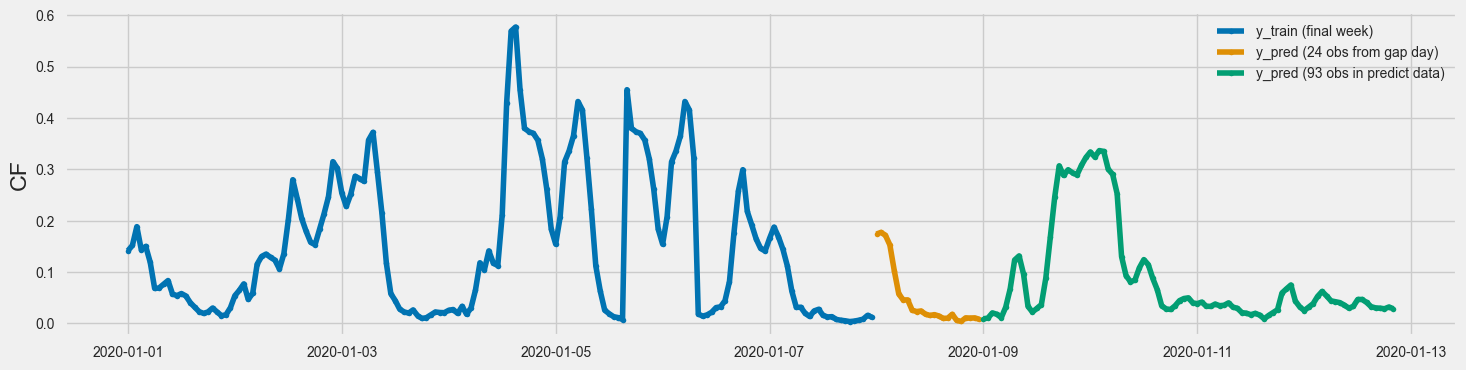

In [707]:
final_plot3 = plot_series(
    y_train.tail(24*7),
    y_pred.head(24),
    y_pred.tail(93),

    labels=[
        'y_train (final week)',

        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )
final_plot3

fig.set_size_inches(25, 8)

ax.set_title(f'Training Data vs Predict Data (Last Week of Training Data (168 rows), All {len(y_pred)} rows of Predict Data)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [708]:
print(y_pred.index[0])
print(X_test.index[0])

assert X_test.index[0] == y_pred.index[0]

In [709]:
df_predict = pd.DataFrame(
    {response_var: y_pred},
    index=X_test.index
)

df_predict


CF
2020-01-08 00:00:00  0.173876
2020-01-08 01:00:00  0.177194
2020-01-08 02:00:00  0.171580
2020-01-08 03:00:00  0.152756
2020-01-08 04:00:00  0.102149
...                       ...
2020-01-12 16:00:00  0.030216
2020-01-12 17:00:00  0.029689
2020-01-12 18:00:00  0.028549
2020-01-12 19:00:00  0.031978
2020-01-12 20:00:00  0.028542

[117 rows x 1 columns]

Although I made prediction for the 24 hourly time periods on 2020-01-08 (and showed them in the plots), I was not asked to give prediction on those, so I will not save them to .csv in the final step.

In [710]:
df_predict.tail(93).to_csv(os.path.join(OUTPUT_DIR, "Predict_CF.csv"))

# The End

---